In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

# Understanding the task

The goal of this competition is to predict the Severity Impairment Index (sii), which measures the level of problematic internet usage among children and adolescents, based on physical activity data and other features.

Target Variable (sii) is defined as:
- 0: None
- 1: Mild
- 2: Moderate
- 3: Severe  

This makes sii an ordinal categorical variable with four levels, where the order of categories is meaningful.

Type of Machine Learning Problem we can use:

1. Ordinal classification (ordinal logistic regression, models with custom ordinal loss functions)
2. Multiclass classification (treat sii as a nominal categorical variable without considering the order)
3. Regression (ignore the discrete nature of categories and treat sii as a continuous variable, then round prediction)
4. Custom (e.g. loss functions that penalize errors based on the distance between categories)


But first, let's make some exploratory data analysis.

# Data Preview

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

### Train data

In [4]:
display(train.head())
print(f"Train shape: {train.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 82)


### Test data

In [5]:
display(test.head())
print(f"Test shape: {test.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test shape: (20, 59)


### Data dictionary

In [6]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


Helper functions

In [7]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({col: formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

# Target Variable and Related Features

Let's identify features that are not present in the test set (related to the target variable, as AmbrosM already mentioned in his [PIU EDA which makes sense](https://www.kaggle.com/code/ambrosm/piu-eda-which-makes-sense) notebook).

In [8]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


**PCIAT-Parent-Child Internet Addiction Test:** contains 20 items, each assessing a different aspect of a child's behavior related to internet use. The items are answered on a scale (from 0 to 5), and the total score provides an indication of the severity of internet addiction. So these features are directly related to the target variable (sii).

We also have Season of participation and Total Score - 22 PCIAT test-related columns in total.

Verify that the PCIAT-PCIAT_Total scores align with the corresponding sii categories by calculating the minimum and maximum PCIAT-PCIAT_Total scores for each sii category:

In [9]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [10]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

### Check missing answers

In [11]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


Let's check if PCIAT-PCIAT_Total was indeed calculated as a sum of non-NA values in  PCIAT-PCIAT_01 to PCIAT-PCIAT_20 columns:

In [12]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
train_with_sii['recalculated_total_score'] = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(train_with_sii['recalculated_total_score'] ==
 train_with_sii['PCIAT-PCIAT_Total']).all()

True

For now, we can conclude that the SII score is sometimes incorrect (e.g. for the second row above with index 93 - most answers are missing and SII = 0). To correct this, we need to recalculate the total score and the SII taking into account the missing values. 

Below I recalculate SII score based on PCIAT_Total and the possible maximum score if missing values were answered as the maximum (5), ensuring the recalculated sii matches the intended thresholds even with some missing responses.

In [13]:
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

In [14]:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
270,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
368,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
592,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
724,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan
877,5.000000,5.000000,5.000000,4.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,4.000000,nan,4.000000,5.000000,5.000000,1.000000,5.000000,0.000000,5.000000,5.000000,78.000000,2.000000,nan


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: Well, for 17 rows the target variable was calculated incorrectly (ignoring missing responses).
</div>

In [15]:
train['sii'] = train['recalc_sii']

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train.drop(columns='recalc_sii', inplace=True)

### Plot distribution of target variable

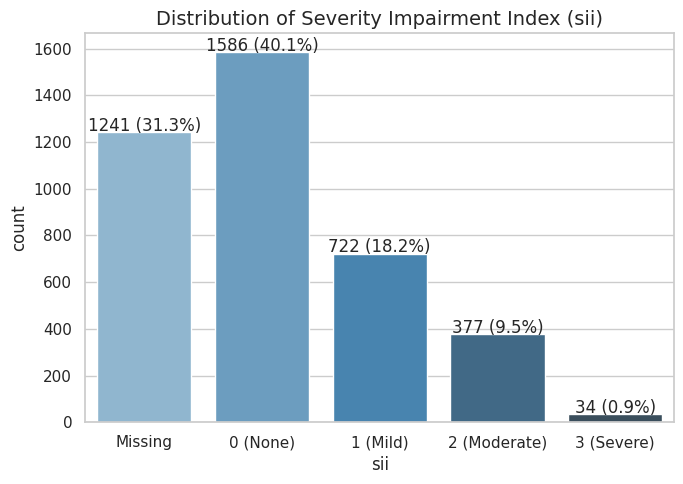

In [16]:
sii_counts = train['sii'].value_counts().reset_index()
sii_counts.columns = ['sii', 'count']

total_count = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total_count) * 100

plt.figure(figsize=(7, 5))
ax = sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d')

plt.title('Distribution of Severity Impairment Index (sii)', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: Apparently, 40% of the participants were not affected by Internet use, 31% were not assessed, and only the minority (~10%) are moderately to severely impaired. 
</div>

### SII by age and sex

In [17]:
assert train['Basic_Demos-Age'].isna().sum() == 0
assert train['Basic_Demos-Sex'].isna().sum() == 0

In [18]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)

sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)

In [19]:
calculate_stats(train, 'Age Group')

,Age Group
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


In [20]:
calculate_stats(train, 'Basic_Demos-Sex')

,Basic_Demos-Sex
Basic_Demos-Sex,
Male,2484 (62.73%)
Female,1476 (37.27%)


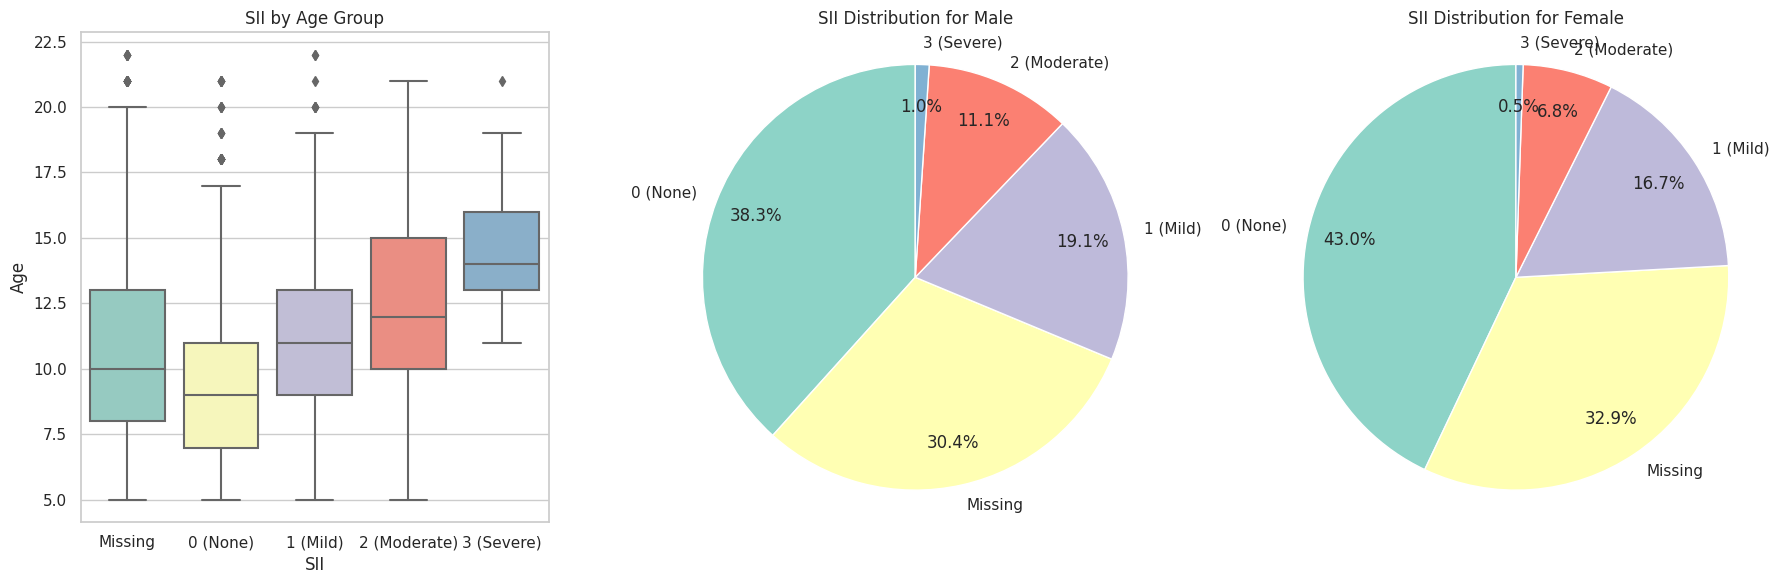

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# SII by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['sii'], ax=axes[0], palette="Set3")
axes[0].set_title('SII by Age Group')
axes[0].set_ylabel('Age')
axes[0].set_xlabel('SII')

# SII by Sex
for i, sex in enumerate(['Male', 'Female']):
    subset = train[train['Basic_Demos-Sex'] == sex]
    group_counts = subset['sii'].value_counts(normalize=True)
    axes[i + 1].pie(
        group_counts, 
        labels=group_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette("Set3"),
        pctdistance=0.80
    )
    axes[i + 1].set_title(f'SII Distribution for {sex}')
    axes[i + 1].axis('equal')

plt.tight_layout()
plt.show()

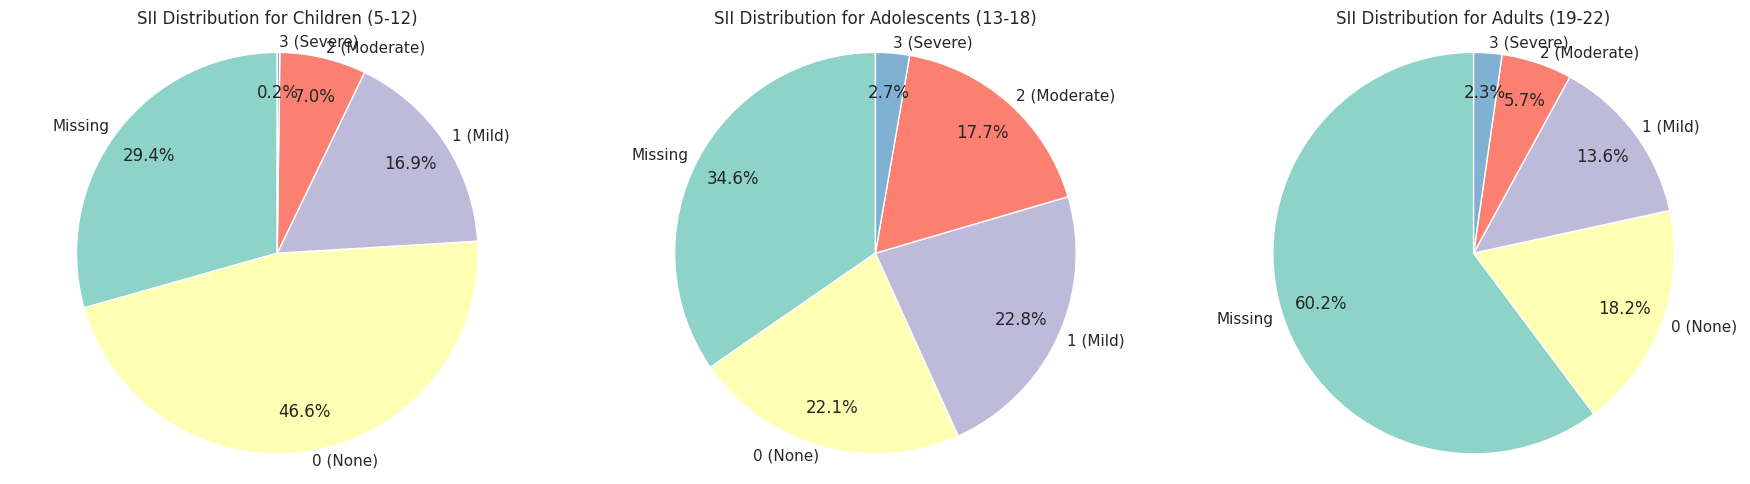

In [22]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [23]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,Missing,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,,
Children (5-12),858 (29.4%),1359 (46.6%),493 (16.9%),203 (7.0%),6 (0.2%)
Adolescents (13-18),330 (34.6%),211 (22.1%),217 (22.8%),169 (17.7%),26 (2.7%)
Adults (19-22),53 (60.2%),16 (18.2%),12 (13.6%),5 (5.7%),2 (2.3%)


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Most children are not severely impaired, higher levels of SII are associated with older age groups
<li>Adolescents (13-18) appear to have a broader distribution of SII scores compared to children and adults, with one-third being moderately to severely affected.
<li>Of the very few adults in this dataset, 60.2% have no SII and 18.2% have None (0).
<li>The differences between males and females are relatively subtle.
    </ul>
</div>

# Internet Use

Internet usage data is crucial to this task because Problematic internet use (PIU), also known as internet addiction or compulsive internet use, refers to excessive and unhealthy use of the internet that interferes with a person’s daily life, responsibilities, and social relationships. The internet usage data provides a direct measure of how much time each participant spends online.

In [24]:
train['PreInt_EduHx-computerinternet_hoursday'].isna().sum() == 0

False

In [25]:
data = train[train['PreInt_EduHx-computerinternet_hoursday'].notna()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with PreInt_EduHx-computerinternet_hoursday data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with PreInt_EduHx-computerinternet_hoursday data: 5 - 22 years


In [26]:
train['PreInt_EduHx-computerinternet_hoursday'].unique()

array([ 3.,  0.,  2., nan,  1.])

In [27]:
param_map = {0: '0 h', 1: '1 h', 2: '2 h', 3: '3 h'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '0 h', '1 h', '2 h', '3 h']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

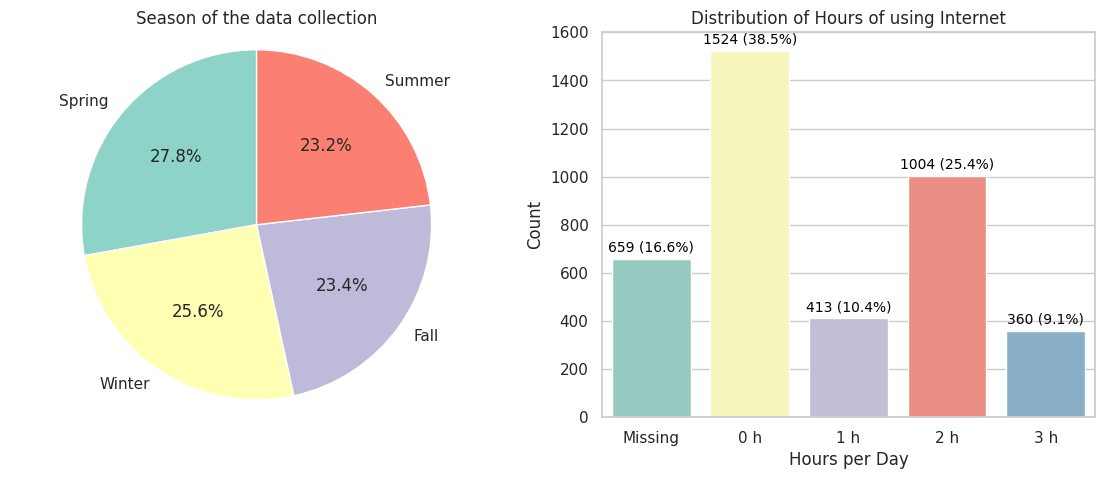

In [28]:
plt.figure(figsize=(14, 5))

# PreInt_EduHx-Season
plt.subplot(1, 2, 1)
group_counts = train['PreInt_EduHx-Season'].value_counts(normalize=True)
plt.pie(
    group_counts, 
    labels=group_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
plt.title('Season of the data collection')
plt.axis('equal')

# PreInt_EduHx-computerinternet_hoursday
plt.subplot(1, 2, 2)
ax = sns.countplot(x='internet_use_encoded', data=train, palette="Set3")
plt.title('Distribution of Hours of using Internet')
plt.xlabel('Hours per Day')
plt.ylabel('Count')

# Add counts and percentages above the bars
total = len(train['internet_use_encoded'])
for p in ax.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

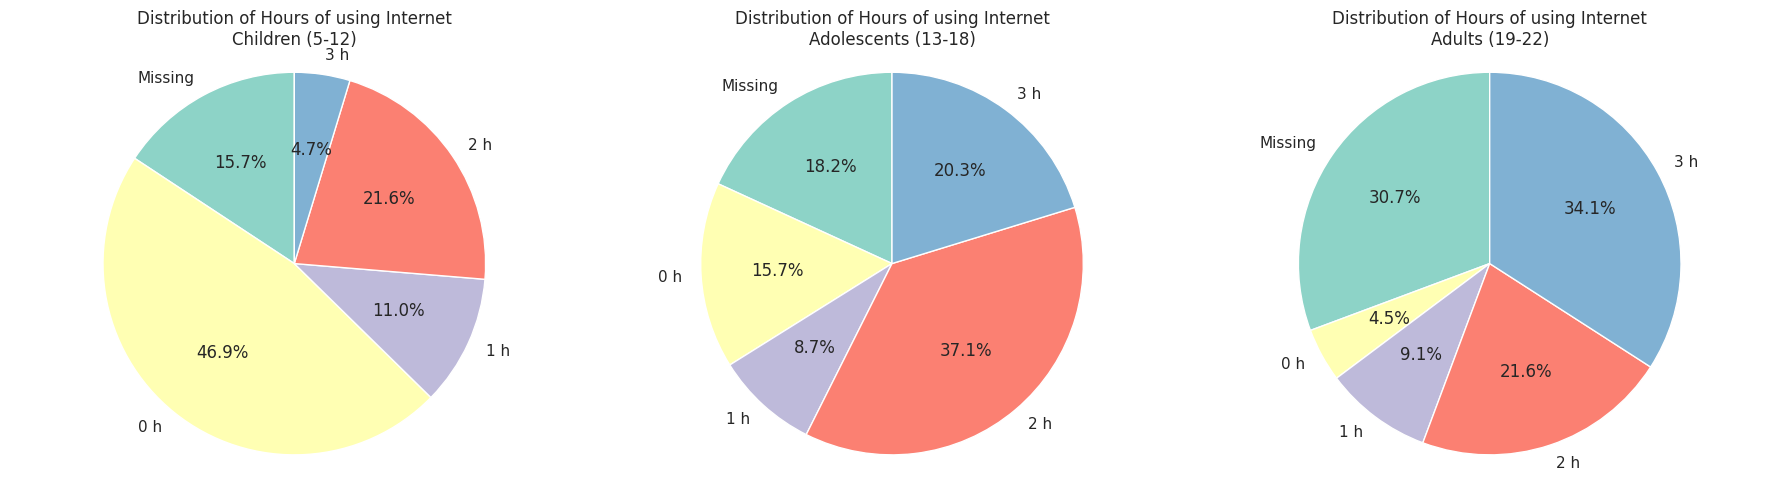

In [29]:
stats = train.groupby(
    ['Age Group', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(group_counts, labels=group_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1)
    axes[i].set_title(f'Distribution of Hours of using Internet\n{age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [30]:
calculate_stats(train, 'internet_use_encoded')

,internet_use_encoded
internet_use_encoded,
Missing,659 (16.64%)
0 h,1524 (38.48%)
1 h,413 (10.43%)
2 h,1004 (25.35%)
3 h,360 (9.09%)


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
        <li>Internet usage data is missing for 16.6% of participants, while 38.5% reported not using the Internet at all.
        <li>For me, there is no extreme internet users in this dataset, as maximum use is 3 hours per day 😜
        <li>Half of the children (46.9%) in the dataset do not spend time on the internet, but a considerable proportion (26.3%) spend 2-3 hours a day.
        <li>A significant portion of adolescents spend 2 hours per day online, and 57.4% spend 2-3 hours.
        <li>Adults have the least representation in this dataset, but 55.7% use Internet 2-3 hours per day.
    </ul>
</div>

### Internet usage vs SII (target)

Competition description states that the goal is: to detect early indicators of problematic Internet and technology use (PIU), while the definition of PUI includes excessive use of internet:

> PUI is an umbrella term that encompasses a set of potentially harmful online behaviors that are repetitive and uncontrolled, to the point that they are prioritized over other life interests and persist despite negative consequences.

*[Fendel, J. C., Vogt, A., Brandtner, A., & Schmidt, S. (2024). Mindfulness programs for problematic usage of the internet: A systematic review and meta-analysis. Journal of behavioral addictions, 13(2), 327–353.](https://doi.org/10.1556/2006.2024.00024)*

So let's see how much time the participants with different impairment scores (SII) spent online in this dataset.

In [31]:
sii_reported = train[train['sii'] != "Missing"]
sii_reported.loc[:, 'sii'] = sii_reported['sii'].cat.remove_unused_categories()

In [32]:
stats = sii_reported.groupby(
    ['internet_use_encoded', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,0 (None),1 (Mild),2 (Moderate),3 (Severe)
internet_use_encoded,,,,
Missing,52 (63.4%),15 (18.3%),15 (18.3%),0 (0.0%)
0 h,933 (73.9%),247 (19.6%),78 (6.2%),5 (0.4%)
1 h,160 (47.2%),123 (36.3%),54 (15.9%),2 (0.6%)
2 h,366 (47.2%),251 (32.3%),147 (18.9%),12 (1.5%)
3 h,75 (29.0%),86 (33.2%),83 (32.0%),15 (5.8%)


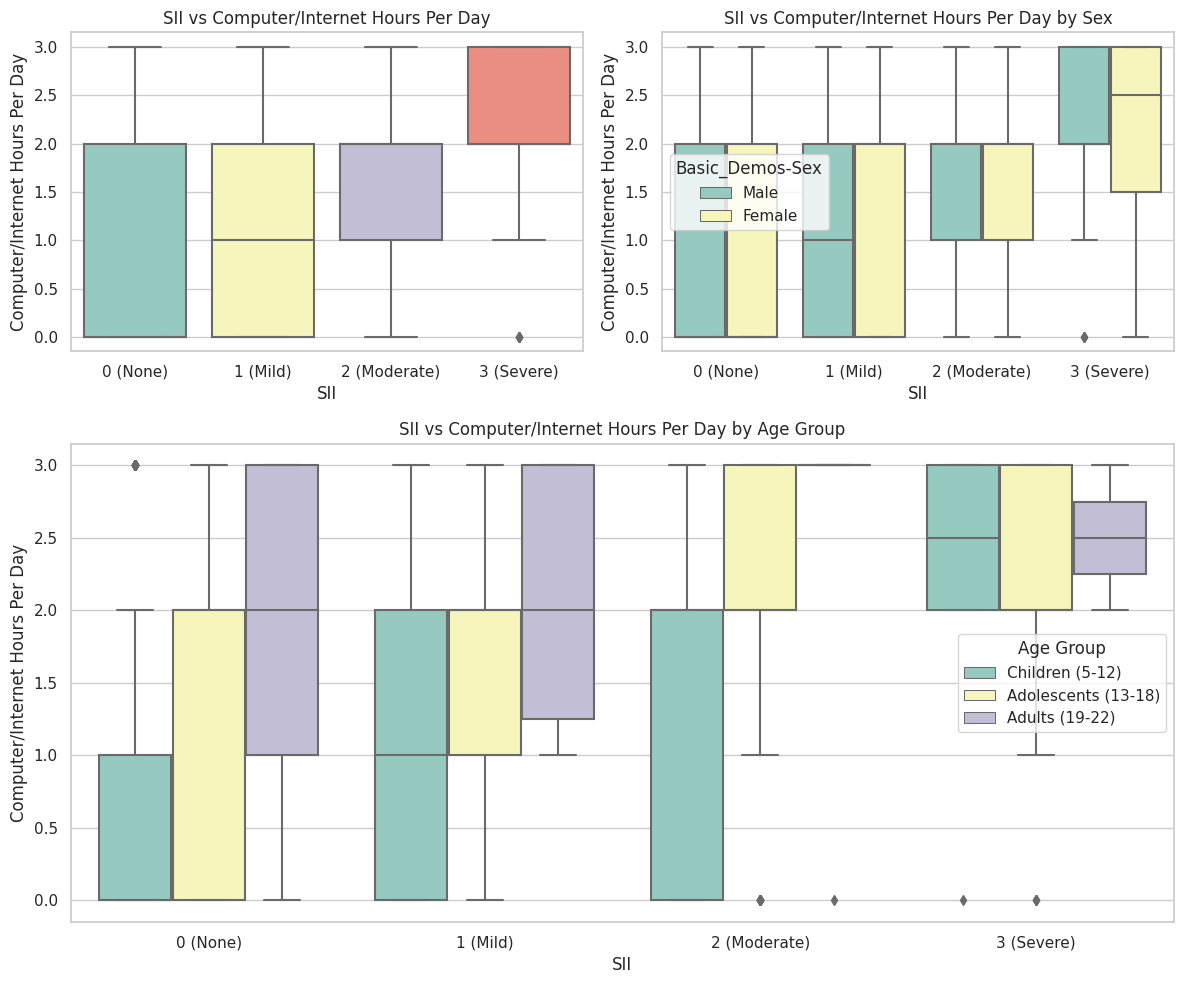

In [33]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.5], width_ratios=[1, 1])

# SII vs Computer/Internet Hours Per Day
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(
    x='sii', y='PreInt_EduHx-computerinternet_hoursday',
    data=sii_reported,
    ax=ax1, palette="Set3"
)
ax1.set_title('SII vs Computer/Internet Hours Per Day')
ax1.set_ylabel('Computer/Internet Hours Per Day')
ax1.set_xlabel('SII')
ax1.set_xticklabels(['0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)'])

# SII vs Computer/Internet Hours Per Day by Sex
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(
    x='sii', y='PreInt_EduHx-computerinternet_hoursday',
    data=sii_reported,
    hue='Basic_Demos-Sex', ax=ax2, palette="Set3" 
)
ax2.set_title('SII vs Computer/Internet Hours Per Day by Sex')
ax2.set_ylabel('Computer/Internet Hours Per Day')
ax2.set_xlabel('SII')
ax2.set_xticklabels(['0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)'])

# SII vs Computer/Internet Hours Per Day by Age Group
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(x='sii', y='PreInt_EduHx-computerinternet_hoursday',
            data=sii_reported,
            hue='Age Group', ax=ax3, palette="Set3")
ax3.set_title('SII vs Computer/Internet Hours Per Day by Age Group')
ax3.set_ylabel('Computer/Internet Hours Per Day')
ax3.set_xlabel('SII')
ax3.set_xticklabels(['0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)'])

plt.tight_layout()
plt.show()

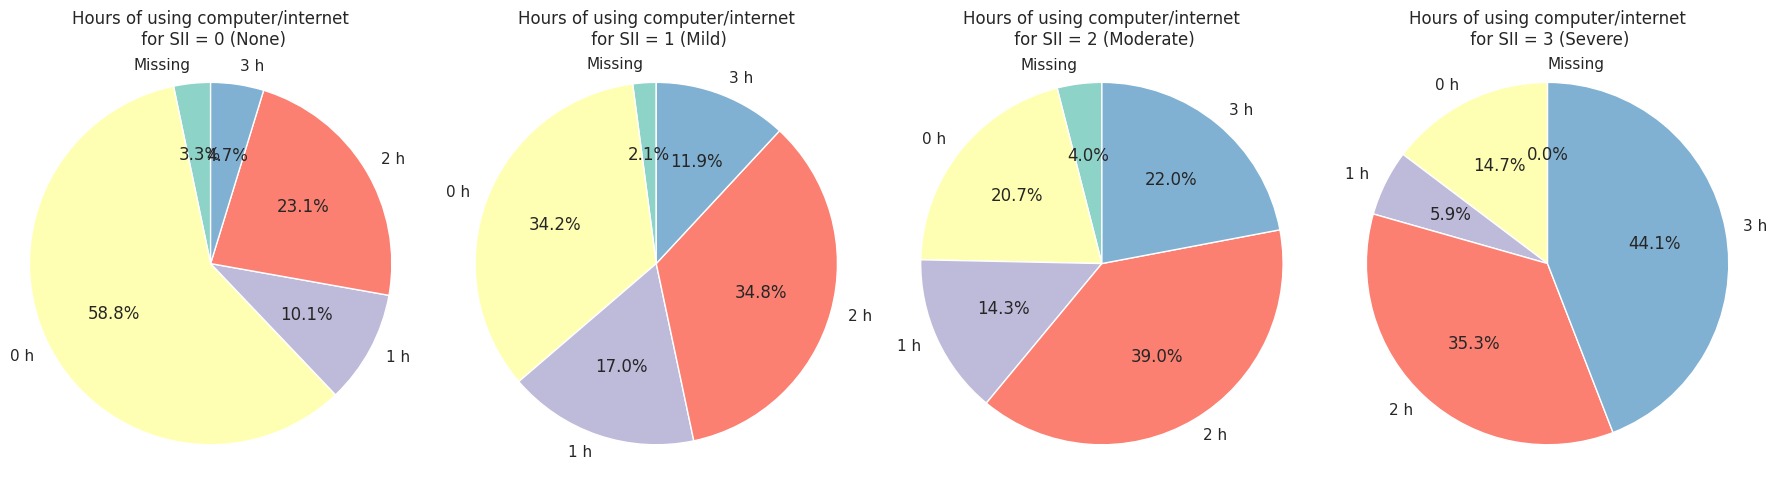

In [34]:
stats = sii_reported.groupby(
    ['sii', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, sii_group in enumerate(stats.index):
    group_counts = stats.loc[sii_group] / stats.loc[sii_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1
    )
    axes[i].set_title(f'Hours of using computer/internet\n for SII = {sii_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>There seems to be a potential positive trend between the SII and Internet use, with individuals with higher SII scores spending more time online.
<li>Adults (19-22) appear to spend more time on the Internet compared to children and adolescents across all severity categories. The more time adults spend online, the higher the SII score, which is expected.
<li>There is a significant proportion of participants (20.7% with SII 2 - moderately impaired and 14.7% with SII = 3 - severely impaired by problematic Internet use) who do not use the Internet (0 hours per day) but have high SII scores (investigator bias or unreliable self-report??).
    </ul>
</div>

# Features EDA by Groups

Here’s how we can classify types of the features in this dataset:

- Categorical: Variables with discrete categories but no inherent order (represented as strings, e.g., season of enrollment)
- Encoded categorical features (already encoded as integers, e.g. sex)
- Continuous: Variables that can take any value within a range (e.g., age, enmo, heart_rate).
- Ordinal: Variables with a defined order but not necessarily equidistant categories (e.g., questionnaire responses, ).

And here are different features groups:

In [35]:
groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()

for instrument, features in groups.items():
    print(f"{instrument}: {features}\n")

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score']

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']

Identifier: ['id']

Internet Use: ['PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']

P

### Season-related columns

The presence of different season-related columns likely reflects the timing of data collection or participation in the study. Seasonal changes may play a significant role in the variables being measured (e.g., fitness, physical activity, sleep patterns, and of course internet usage).

In [36]:
season_columns = [col for col in train.columns if 'Season' in col]
season_df = train[season_columns]
season_df

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
0,Fall,Winter,Fall,NaN,Fall,Fall,NaN,NaN,Fall,NaN,Fall
1,Summer,NaN,Fall,NaN,Fall,Winter,NaN,Fall,Fall,Fall,Summer
2,Summer,Fall,Fall,Fall,Fall,NaN,NaN,Summer,Fall,Fall,Summer
3,Winter,Fall,Summer,Summer,Summer,Summer,NaN,Winter,Summer,Summer,Winter
4,Spring,Summer,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,Spring,Fall,NaN,Fall,Fall,NaN,Winter,Winter,Winter,Fall
3956,Winter,NaN,Spring,NaN,Spring,Spring,NaN,Winter,NaN,NaN,Winter
3957,Fall,Spring,Winter,NaN,Winter,Winter,NaN,Winter,Winter,Winter,Fall
3958,Spring,Spring,Winter,NaN,Spring,Summer,NaN,Spring,Spring,Spring,Spring


In [37]:
train[season_columns] = train[season_columns].fillna("Missing")

Remove target-related columns and continue EDA by feature groups.

In [38]:
data_dict = data_dict[data_dict['Instrument'] != 'Parent-Child Internet Addiction Test']
continuous_cols = data_dict[data_dict['Type'].str.contains(
    'float|int', case=False
)]['Field'].tolist()

# target = train[['sii']]
# train = train.drop(columns = columns_not_in_test)

# - Demographics

In [39]:
groups.get('Demographics', [])

['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

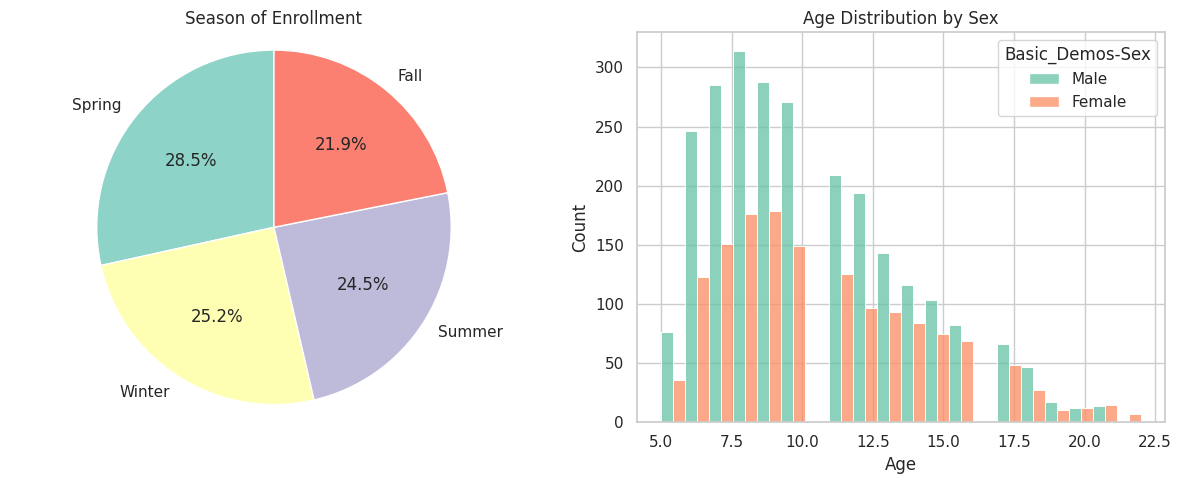

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Season of Enrollment
season_counts = train['Basic_Demos-Enroll_Season'].value_counts(dropna=False)

axes[0].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[0].set_title('Season of Enrollment')
axes[0].axis('equal')

# Age Distribution by Sex
sns.histplot(
    data=train, x='Basic_Demos-Age',
    hue='Basic_Demos-Sex', multiple='dodge',
    palette="Set2", bins=20, ax=axes[1]
)
axes[1].set_title('Age Distribution by Sex')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

0=Male, 1=Female

In [41]:
calculate_stats(train, 'Basic_Demos-Age')

,count,mean,std,min,25%,50%,75%,max,missing
Basic_Demos-Age,,,,,,,,,
Basic_Demos-Age,3960.0,10.433586,3.574648,5.0,8.0,10.0,13.0,22.0,0


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The distribution of enrollment by season is relatively balanced, with the highest enrollment in Spring (28.5%) and the lowest in Fall (21.9%).
<li>There is a higher number of males (0) across most age groups, with fewer females (1) particularly visible in younger age groups.
    </ul>
</div>

# - Physical Measures

In [42]:
groups.get('Physical Measures', [])

['Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP']

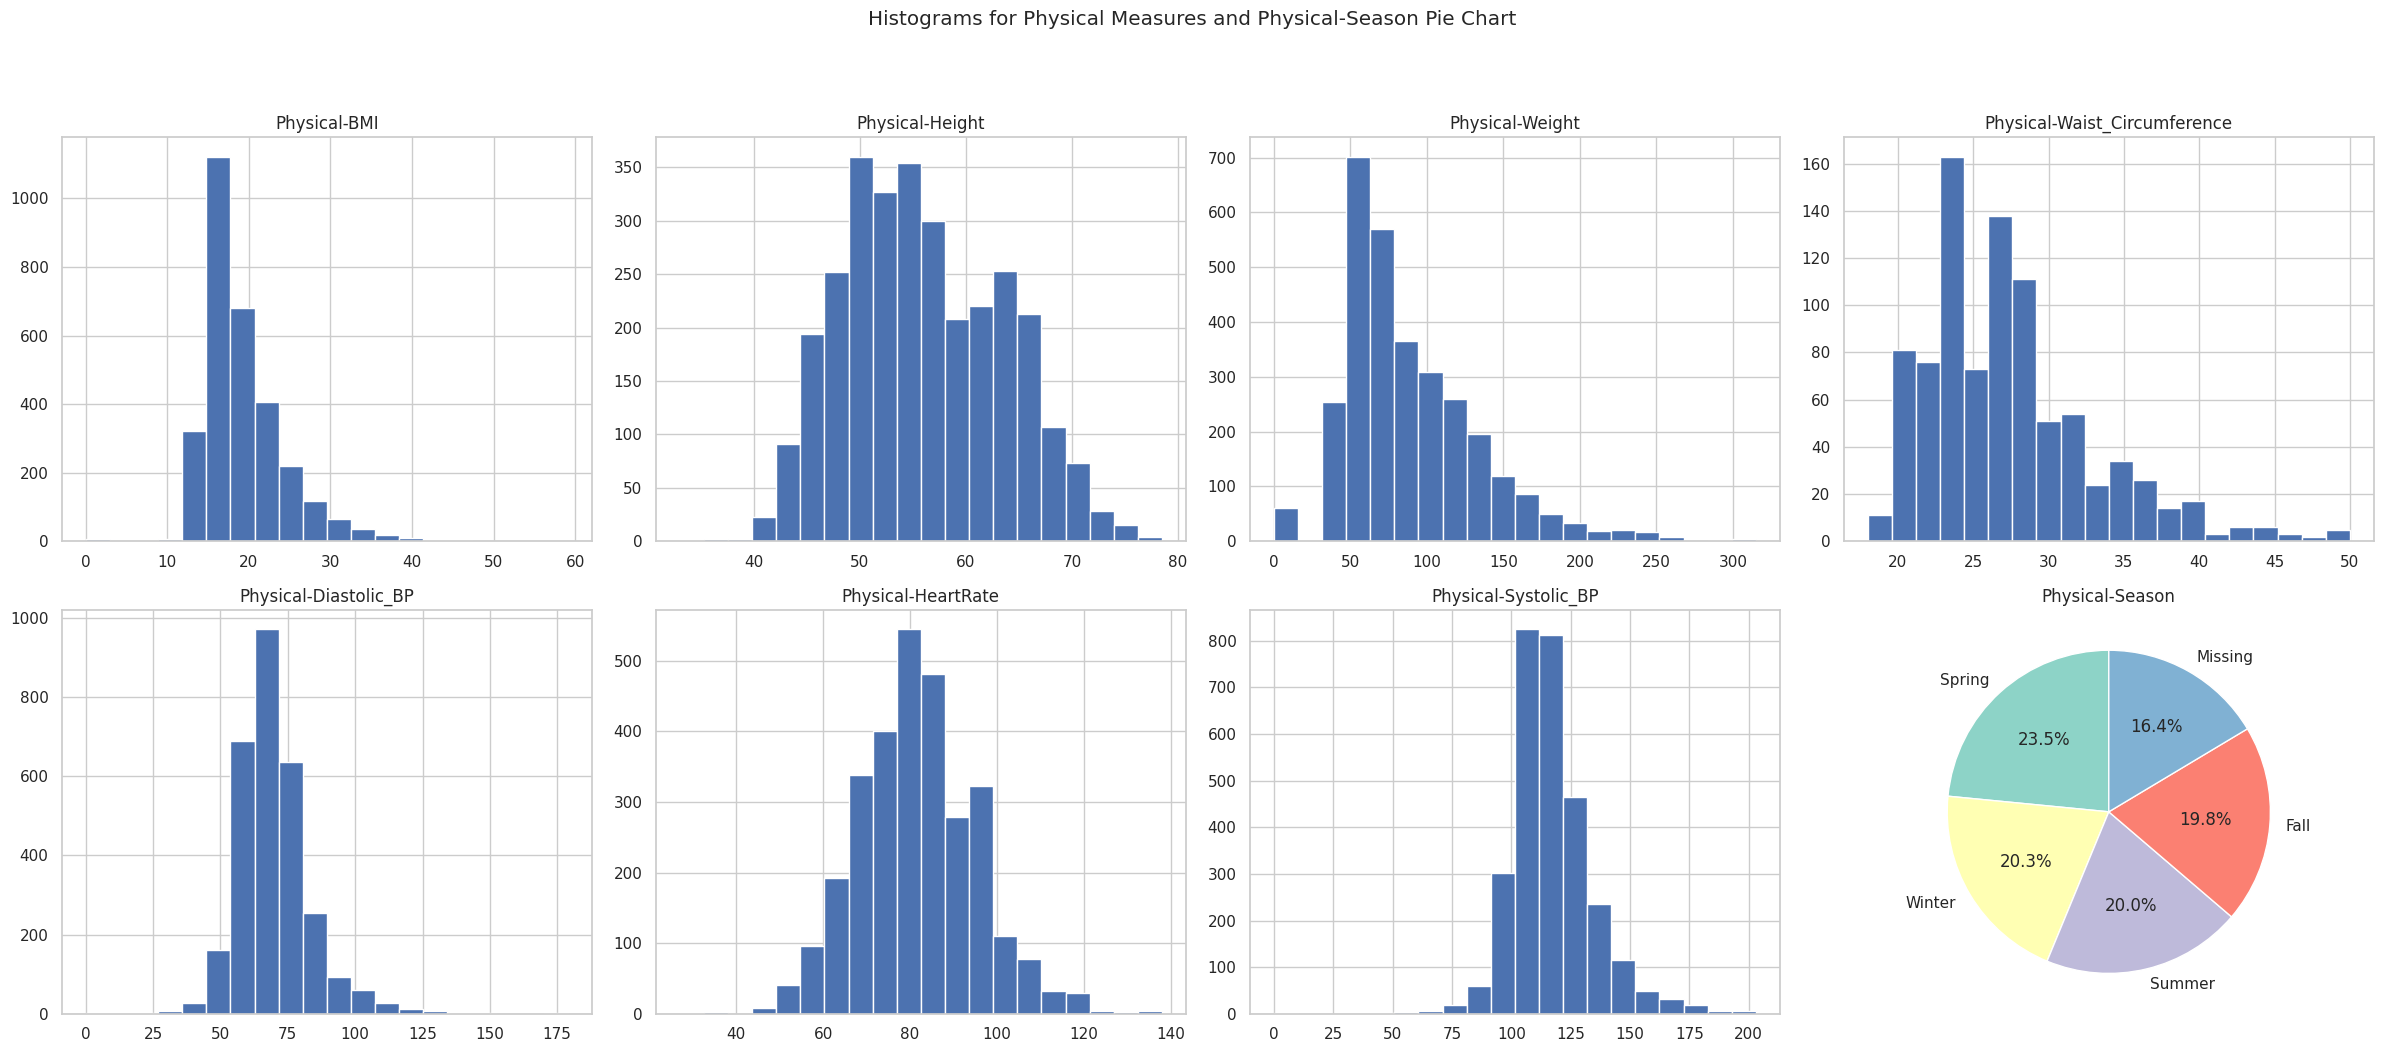

In [43]:
features_physical = groups.get('Physical Measures', [])
cols = [col for col in features_physical if col in continuous_cols]

plt.figure(figsize=(24, 10))
n_cols = 4
n_rows = len(cols) // n_cols + 1

for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i + 1)
    train[col].hist(bins=20)
    plt.title(col)

plt.subplot(n_rows, n_cols, len(cols) + 1)
season_counts = train['Physical-Season'].value_counts(dropna=False)
plt.pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('Physical-Season')

plt.suptitle('Histograms for Physical Measures and Physical-Season Pie Chart', y=1.05)
plt.tight_layout()
plt.show()

In [44]:
calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048,938
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000,933
Physical-Weight,3076.0,89.038615,44.569040,0.0,57.20000,77.000000,113.800000,315.000000,884
Physical-Waist_Circumference,898.0,27.278508,5.567287,18.0,23.00000,26.000000,30.000000,50.000000,3062
Physical-Diastolic_BP,2954.0,69.648951,13.611226,0.0,61.00000,68.000000,76.000000,179.000000,1006
Physical-HeartRate,2967.0,81.597236,13.665196,27.0,72.00000,81.000000,90.500000,138.000000,993
Physical-Systolic_BP,2954.0,116.983074,17.061225,0.0,107.00000,114.000000,125.000000,203.000000,1006


The minimum values of 0 for measures like BMI, weight, and blood pressure are biologically unrealistic, and likely indicate missing or erroneous data. Let's  check number of zeros in these columns:

In [45]:
(train[cols] == 0).sum()

Physical-BMI                     7
Physical-Height                  0
Physical-Weight                 61
Physical-Waist_Circumference     0
Physical-Diastolic_BP            1
Physical-HeartRate               0
Physical-Systolic_BP             1
dtype: int64

Replace the 0 values by NaN and check the stats again:

In [46]:
train[cols] = train[cols].replace(0, np.nan)
calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3015.0,19.376812,5.034191,8.522436,15.890526,17.950925,21.588631,59.132048,945
Physical-Height,3027.0,55.946713,7.473764,33.000000,50.000000,55.000000,62.000000,78.500000,933
Physical-Weight,3015.0,90.840060,43.161374,31.800000,58.200000,77.800000,114.300000,315.000000,945
Physical-Waist_Circumference,898.0,27.278508,5.567287,18.000000,23.000000,26.000000,30.000000,50.000000,3062
Physical-Diastolic_BP,2953.0,69.672536,13.553022,11.000000,61.000000,68.000000,76.000000,179.000000,1007
Physical-HeartRate,2967.0,81.597236,13.665196,27.000000,72.000000,81.000000,90.500000,138.000000,993
Physical-Systolic_BP,2953.0,117.022689,16.927687,49.000000,107.000000,114.000000,125.000000,203.000000,1007


Convert weight to kilograms, and height to centimeters:

In [47]:
lbs_to_kg = 0.453592
inches_to_cm = 2.54

train['Physical-Weight'] = train['Physical-Weight'] * lbs_to_kg
train['Physical-Height'] = train['Physical-Height'] * inches_to_cm
train['Physical-Waist_Circumference'] = train['Physical-Waist_Circumference'] * inches_to_cm

# Recalculate BMI: BMI = weight (kg) / (height (m)^2)
train['Physical-BMI'] = np.where(
    train['Physical-Weight'].notna() & train['Physical-Height'].notna(),
    train['Physical-Weight'] / ((train['Physical-Height'] / 100) ** 2),
    np.nan  # If either is NaN, set BMI to NaN
)

calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3015.0,19.378674,5.034658,8.523273,15.892086,17.952687,21.590750,59.137852,945
Physical-Height,3027.0,142.104651,18.983360,83.820000,127.000000,139.700000,157.480000,199.390000,933
Physical-Weight,3015.0,41.204324,19.577654,14.424226,26.399054,35.289458,51.845566,142.881480,945
Physical-Waist_Circumference,898.0,69.287410,14.140909,45.720000,58.420000,66.040000,76.200000,127.000000,3062
Physical-Diastolic_BP,2953.0,69.672536,13.553022,11.000000,61.000000,68.000000,76.000000,179.000000,1007
Physical-HeartRate,2967.0,81.597236,13.665196,27.000000,72.000000,81.000000,90.500000,138.000000,993
Physical-Systolic_BP,2953.0,117.022689,16.927687,49.000000,107.000000,114.000000,125.000000,203.000000,1007


A lot of values seem to be out of normal ranges... especially max values of weight (142kg) and blood pressure (very high hipertonic).

### Weight and Height

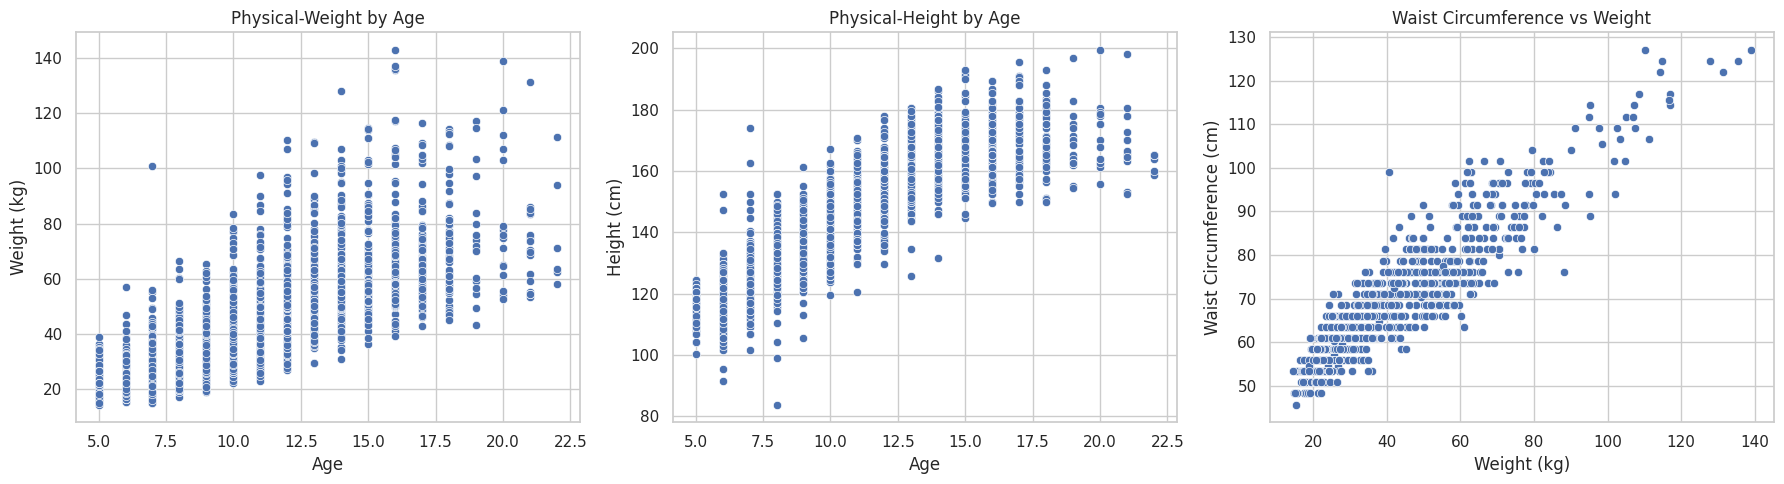

In [48]:
plt.figure(figsize=(18, 5))

# Physical-Weight by Age
plt.subplot(1, 3, 1)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Weight', data=train)
plt.title('Physical-Weight by Age')
plt.xlabel('Age')
plt.ylabel('Weight (kg)')

# Physical-Height by Age
plt.subplot(1, 3, 2)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Height', data=train)
plt.title('Physical-Height by Age')
plt.xlabel('Age')
plt.ylabel('Height (cm)')

# Physical-Waist_Circumference vs Physical-Weight
plt.subplot(1, 3, 3)
sns.scatterplot(x='Physical-Weight', y='Physical-Waist_Circumference', data=train)
plt.title('Waist Circumference vs Weight')
plt.xlabel('Weight (kg)')
plt.ylabel('Waist Circumference (cm)')

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Weight and height both increase with age, and waist circumference and weight are highly correlated, which is to be expected.
<li>However, there are individuals who are unusually tall for their age group or who are extremely overweight.
<li>There are also a few outliers in the waist circumference measurements, which are possible artifacts (e.g. 100 cm for a weight of 40 kg).
    </ul>
</div>

### Blood pressure vs Body Mass Index (BMI)

Typically, systolic (SBP) and diastolic (DBP) blood pressure are positively correlated, as they both reflect the functioning of the cardiovascular system. However, there can be deviations:

- Isolated Systolic Hypertension: High SBP with normal DBP
- Isolated Diastolic Hypertension: Normal SBP with high DBP
- General Hypertension: Both SBP and DBP are elevated

BMI is often used as an indicator of overall body fat and can correlate with blood pressure (e.g. higher BMI values indicating overweight or obesity are commonly associated with elevated blood pressure). Let's see if this is true for the study participants.

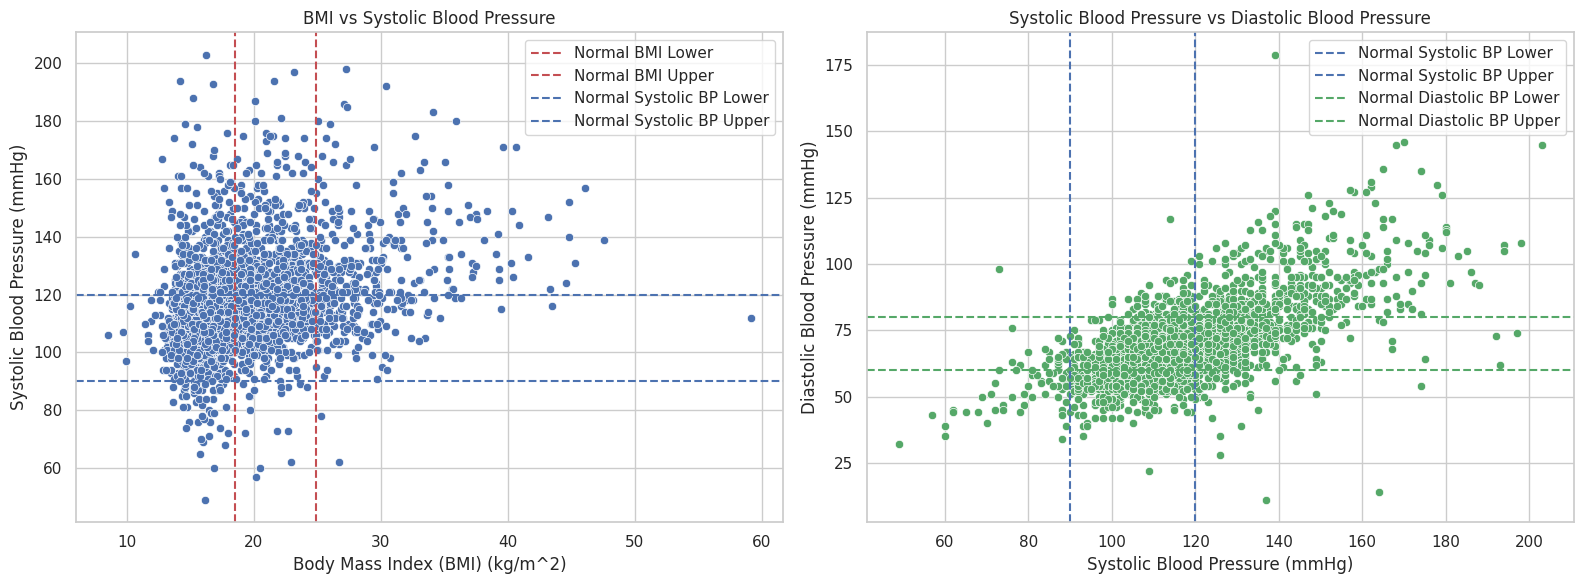

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BMI vs Systolic Blood Pressure
sns.scatterplot(x='Physical-BMI', y='Physical-Systolic_BP', data=train, ax=axes[0], color='b')
axes[0].set_title('BMI vs Systolic Blood Pressure')
axes[0].set_xlabel('Body Mass Index (BMI) (kg/m^2)')
axes[0].set_ylabel('Systolic Blood Pressure (mmHg)')

# Reference lines for Systolic BP and BMI
axes[0].axvline(x=18.5, color='r', linestyle='--', label='Normal BMI Lower')
axes[0].axvline(x=24.9, color='r', linestyle='--', label='Normal BMI Upper')
axes[0].axhline(y=90, color='b', linestyle='--', label='Normal Systolic BP Lower')
axes[0].axhline(y=120, color='b', linestyle='--', label='Normal Systolic BP Upper')
axes[0].legend()

# Systolic Blood Pressure vs Diastolic Blood Pressure
sns.scatterplot(
    x='Physical-Systolic_BP', y='Physical-Diastolic_BP',
    data=train, ax=axes[1], color='g'
)
axes[1].set_title('Systolic Blood Pressure vs Diastolic Blood Pressure')
axes[1].set_xlabel('Systolic Blood Pressure (mmHg)')
axes[1].set_ylabel('Diastolic Blood Pressure (mmHg)')

# Reference lines for Systolic and Diastolic BP
axes[1].axvline(x=90, color='b', linestyle='--', label='Normal Systolic BP Lower')
axes[1].axvline(x=120, color='b', linestyle='--', label='Normal Systolic BP Upper')
axes[1].axhline(y=60, color='g', linestyle='--', label='Normal Diastolic BP Lower')
axes[1].axhline(y=80, color='g', linestyle='--', label='Normal Diastolic BP Upper')
axes[1].legend()

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>There does not appear to be a strong, clear correlation between body mass index (BMI) and systolic blood pressure (BP).
<li>The red dashed lines mark the normal BMI range, while the blue and green dashed lines represent the normal systolic and diastolic BP ranges. A substantial number of points fall outside these ranges, suggesting a mix of underweight/overweight individuals and elevated BP.
<li>As expected, there is a strong positive correlation between systolic and diastolic BP, but there are notable cases of isolated systolic or diastolic hypertension
    </ul>
</div>

### Check Blood Pressure

In [50]:
train[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP']][cols]

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
1140,25.276831,157.4800,62.686414,NaN,179.0,103.0,139.0
1879,19.122276,134.6200,34.654429,NaN,117.0,114.0,114.0
2386,16.596862,129.5400,27.850549,60.96,76.0,116.0,76.0
3344,22.697678,164.0078,61.053483,63.50,98.0,96.0,73.0


These are wrong measurement for sure.

### Blood Pressure vs Heart Rate

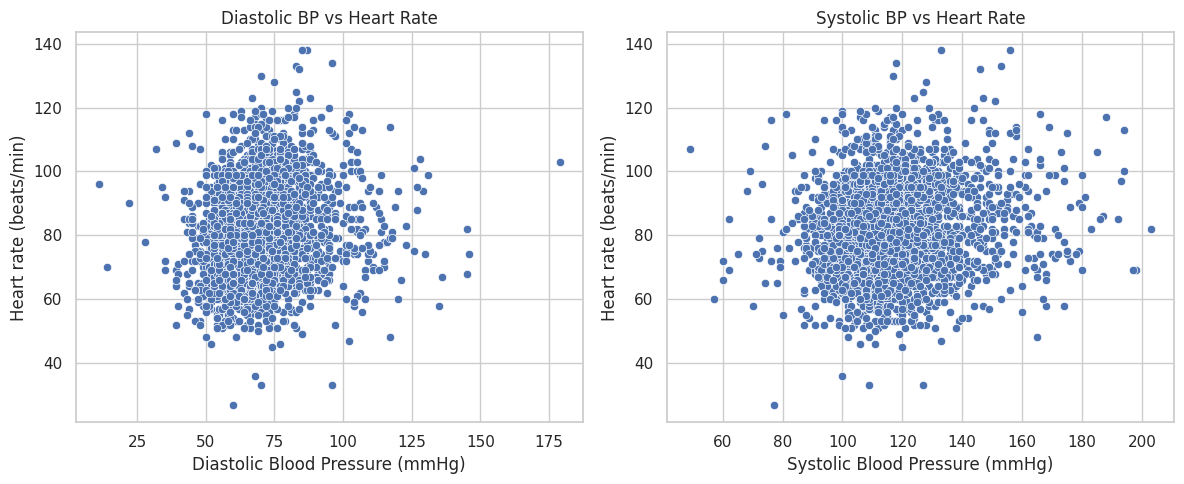

In [51]:
plt.figure(figsize=(12, 5))

# Diastolic BP vs Heart Rate
plt.subplot(1, 2, 1)
sns.scatterplot(x='Physical-Diastolic_BP', y='Physical-HeartRate', data=train)
plt.title('Diastolic BP vs Heart Rate')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

# Systolic BP vs Heart Rate
plt.subplot(1, 2, 2)
sns.scatterplot(x='Physical-Systolic_BP', y='Physical-HeartRate', data=train)
plt.title('Systolic BP vs Heart Rate')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The absence of a clear direct correlation between heart rate and blood pressure in the plots suggests that the measurements were likely taken in a resting state or under non-stressful conditions. 
    </ul>
</div>

### Compare to normal rages 

Now we'll define approximate normal ranges for each column and count the number of rows that fall outside these ranges. As normal values can vary widely between the ages of 5 and 22, **I use values that are general estimates; for more precise results you can refer to BMI-for-age growth charts on the CDC or WHO websites, for example.**

In [52]:
normal_ranges = {
    'Physical-BMI': (18.5, 24.9),
    'Physical-Height': (100, 193),
    'Physical-Weight': (20, 120),
    'Physical-Waist_Circumference': (50, 90),
    'Physical-Diastolic_BP': (60, 80),
    'Physical-HeartRate': (60, 100),
    'Physical-Systolic_BP': (90, 120)
}

def count_out_of_range(data, column, low, high):
    return ((data[column] < low) | (data[column] > high)).sum()

In [53]:
out_of_range_counts = {
    col: count_out_of_range(train, col, *normal_ranges[col])
    for col in normal_ranges
}
print("Number of rows with values outside normal ranges:")

for col, count in out_of_range_counts.items():
    total_valid = train[col].notna().sum()
    percentage = (count / total_valid) * 100
    print(f"{col}: {count} ({percentage:.2f}%)")

Number of rows with values outside normal ranges:
Physical-BMI: 2027 (67.23%)
Physical-Height: 10 (0.33%)
Physical-Weight: 165 (5.47%)
Physical-Waist_Circumference: 93 (10.36%)
Physical-Diastolic_BP: 1022 (34.61%)
Physical-HeartRate: 350 (11.80%)
Physical-Systolic_BP: 1078 (36.51%)


Group BMI by obesity level according to [WHO BMI-for-age (5-19 years)](https://www.who.int/tools/growth-reference-data-for-5to19-years/indicators/bmi-for-age)

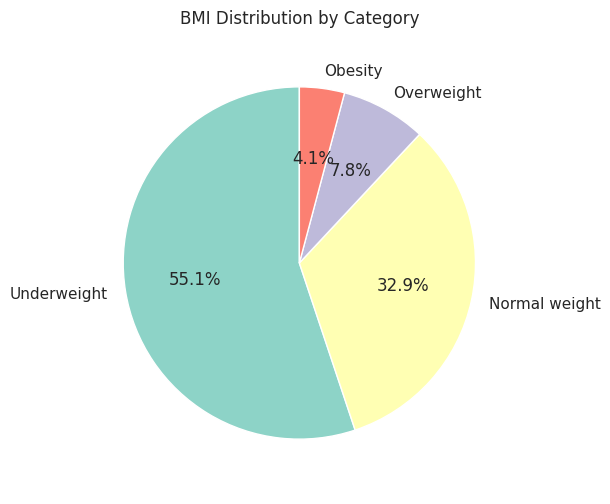

In [54]:
bmi_categories = [
    ('Underweight', train['Physical-BMI'] < 18.5),
    ('Normal weight', (train['Physical-BMI'] >= 18.5) & (train['Physical-BMI'] <= 24.9)),
    ('Overweight', (train['Physical-BMI'] >= 25) & (train['Physical-BMI'] <= 29.9)),
    ('Obesity', train['Physical-BMI'] >= 30)
]
bmi_category_counts = {label: condition.sum() for label, condition in bmi_categories}

plt.figure(figsize=(5, 6))
plt.pie(bmi_category_counts.values(),
        labels=bmi_category_counts.keys(),
        autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Set3.colors)
plt.title('BMI Distribution by Category')
plt.axis('equal')
plt.show()

### Check extreme deviations cases

In [55]:
train[train['Physical-BMI'] < 12][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-BMI')

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Basic_Demos-Age
2848,8.523273,149.860,19.141582,NaN,68.0,77.0,106.0,8
1952,9.694718,149.860,21.772416,NaN,64.0,86.0,107.0,7
3463,9.960144,152.400,23.133192,NaN,48.0,73.0,97.0,6
3324,10.282698,147.320,22.316726,NaN,72.0,72.0,116.0,6
1707,10.676487,162.560,28.213422,NaN,99.0,90.0,134.0,7
3143,11.468414,131.318,19.776611,NaN,59.0,77.0,110.0,8
1700,11.676989,167.005,32.567906,NaN,50.0,90.0,106.0,10
3636,11.713943,139.700,22.861037,NaN,58.0,99.0,104.0,7
1307,11.750716,112.522,14.877818,48.26,NaN,77.0,NaN,7
156,11.916424,149.860,26.761928,71.12,76.0,83.0,118.0,11


In [56]:
train[train['Physical-Systolic_BP'] > 160][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-Systolic_BP')

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Basic_Demos-Age
1794,14.036968,121.920,20.865232,NaN,111.0,69.0,161.0,8
284,21.719865,152.527,50.530149,NaN,96.0,99.0,161.0,12
3032,14.272220,129.540,23.949658,NaN,104.0,89.0,161.0,9
2401,17.245599,129.540,28.939170,NaN,87.0,103.0,161.0,8
882,16.398111,124.460,25.401152,NaN,127.0,95.0,161.0,6
...,...,...,...,...,...,...,...,...
1019,14.172653,124.460,21.953853,60.96,107.0,113.0,194.0,8
2777,21.625191,134.620,39.190349,NaN,105.0,100.0,194.0,7
2549,23.154916,169.926,66.859461,NaN,74.0,69.0,197.0,17
436,27.260353,175.260,83.733083,NaN,108.0,69.0,198.0,19


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
        <li>A significant number of participants, especially for BMI and blood pressure, fall outside the expected normal ranges
        <li>Most of the participants' height and weight values are within reasonable ranges, but 67.23% have a BMI outside the normal range, indicating that many participants may have disproportionate body proportions (or wrong measurements?)
    </ul>
</div>

# - Physical Activity Questionnaire

### Adolescents

In [57]:
groups.get('Physical Activity Questionnaire (Adolescents)', [])

['PAQ_A-Season', 'PAQ_A-PAQ_A_Total']

In [58]:
data = train[train['PAQ_A-PAQ_A_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Adolescents (with PAQ_A_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for Adolescents (with PAQ_A_Total data): 13 - 18 years


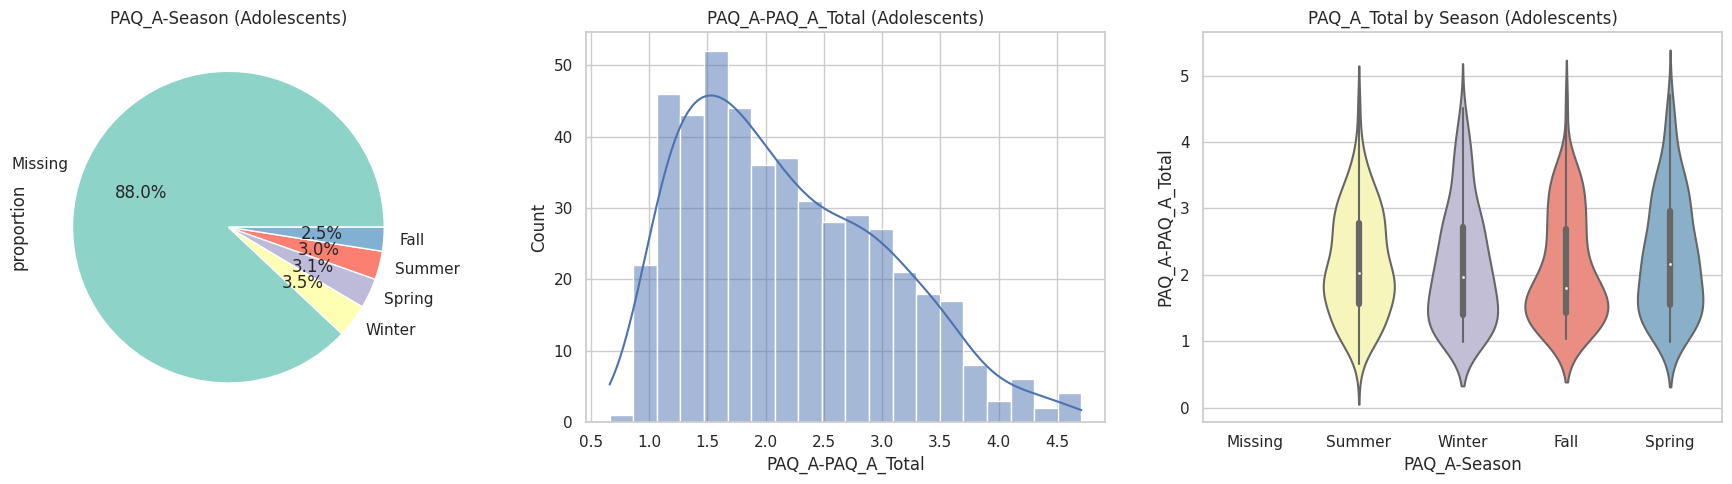

In [59]:
plt.figure(figsize=(18, 5))

# PAQ_A-Season
plt.subplot(1, 3, 1)
train['PAQ_A-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_A-Season (Adolescents)')

# PAQ_A-PAQ_A_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_A-PAQ_A_Total'], bins=20, kde=True)
plt.title('PAQ_A-PAQ_A_Total (Adolescents)')

# PAQ_A_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_A-Season', y='PAQ_A-PAQ_A_Total', data=train, palette="Set3")
plt.title('PAQ_A_Total by Season (Adolescents)')

plt.tight_layout()
plt.show()

In [60]:
calculate_stats(train, ['PAQ_A-PAQ_A_Total'])

,count,mean,std,min,25%,50%,75%,max,missing
PAQ_A-PAQ_A_Total,,,,,,,,,
PAQ_A-PAQ_A_Total,475.0,2.178853,0.849476,0.66,1.49,2.01,2.78,4.71,3485


### Children

In [61]:
groups.get('Physical Activity Questionnaire (Children)', [])

['PAQ_C-Season', 'PAQ_C-PAQ_C_Total']

In [62]:
data = train[train['PAQ_C-PAQ_C_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Children (with PAQ_C_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for Children (with PAQ_C_Total data): 7 - 17 years


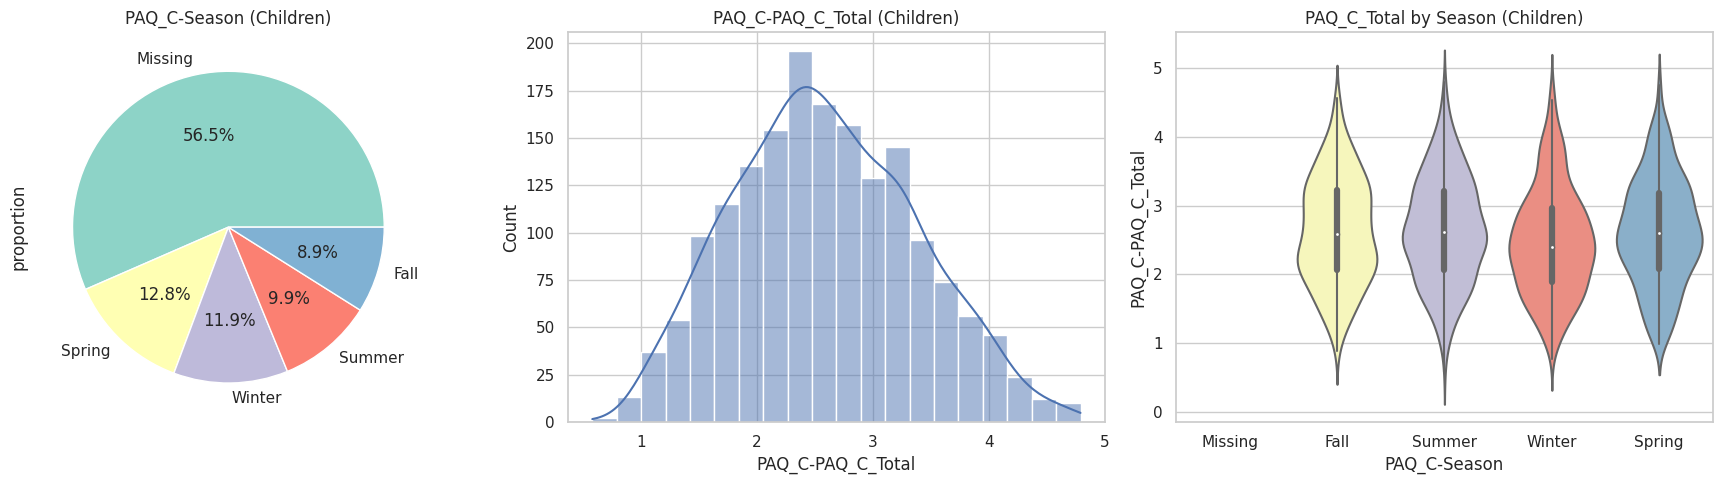

In [63]:
plt.figure(figsize=(18, 5))

# PAQ_C-Season
plt.subplot(1, 3, 1)
train['PAQ_C-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_C-Season (Children)')

# PAQ_C-PAQ_C_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_C-PAQ_C_Total'], bins=20, kde=True)
plt.title('PAQ_C-PAQ_C_Total (Children)')

# PAQ_C_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_C-Season', y='PAQ_C-PAQ_C_Total', data=train, palette="Set3")
plt.title('PAQ_C_Total by Season (Children)')

plt.tight_layout()
plt.show()

In [64]:
calculate_stats(train, ['PAQ_C-PAQ_C_Total'])

,count,mean,std,min,25%,50%,75%,max,missing
PAQ_C-PAQ_C_Total,,,,,,,,,
PAQ_C-PAQ_C_Total,1721.0,2.58955,0.783937,0.58,2.02,2.54,3.16,4.79,2239


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The division into adolescents and children seems to be incorrect (participants with data in the children columns (PAQ_C_Total) are 7 - 17 years old - overlapping with those with non-missing data in the adolescents columns - 13 - 18 years old).
<li>Physical activity levels are fairly stable over the seasons, with only minor variations, although are slightly lower in the fall and winter for adolescents and children, respectively.
<li>There are many missing values for these features
    </ul>
</div>

Check if any participants have data for both the children's PAQ (PAQ_C) and adolescents' PAQ (PAQ_A) columns

In [65]:
paq_columns = [col for col in train.columns if 'PAQ' in col]
train[(train['PAQ_A-PAQ_A_Total'].notnull()) &
      (train['PAQ_C-PAQ_C_Total'].notnull())][
    paq_columns + ['Basic_Demos-Age']
]

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,Basic_Demos-Age
3331,Summer,2.27,Spring,2.32,13


May be it will make sense to combine PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total into a single column and take the average when both values are present.

# - FitnessGram

### FitnessGram Vitals and Treadmill

In [66]:
groups.get('FitnessGram Vitals and Treadmill', [])

['Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec']

In [67]:
data = train[train['Fitness_Endurance-Max_Stage'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with Fitness_Endurance-Max_Stage data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with Fitness_Endurance-Max_Stage data: 6 - 12 years


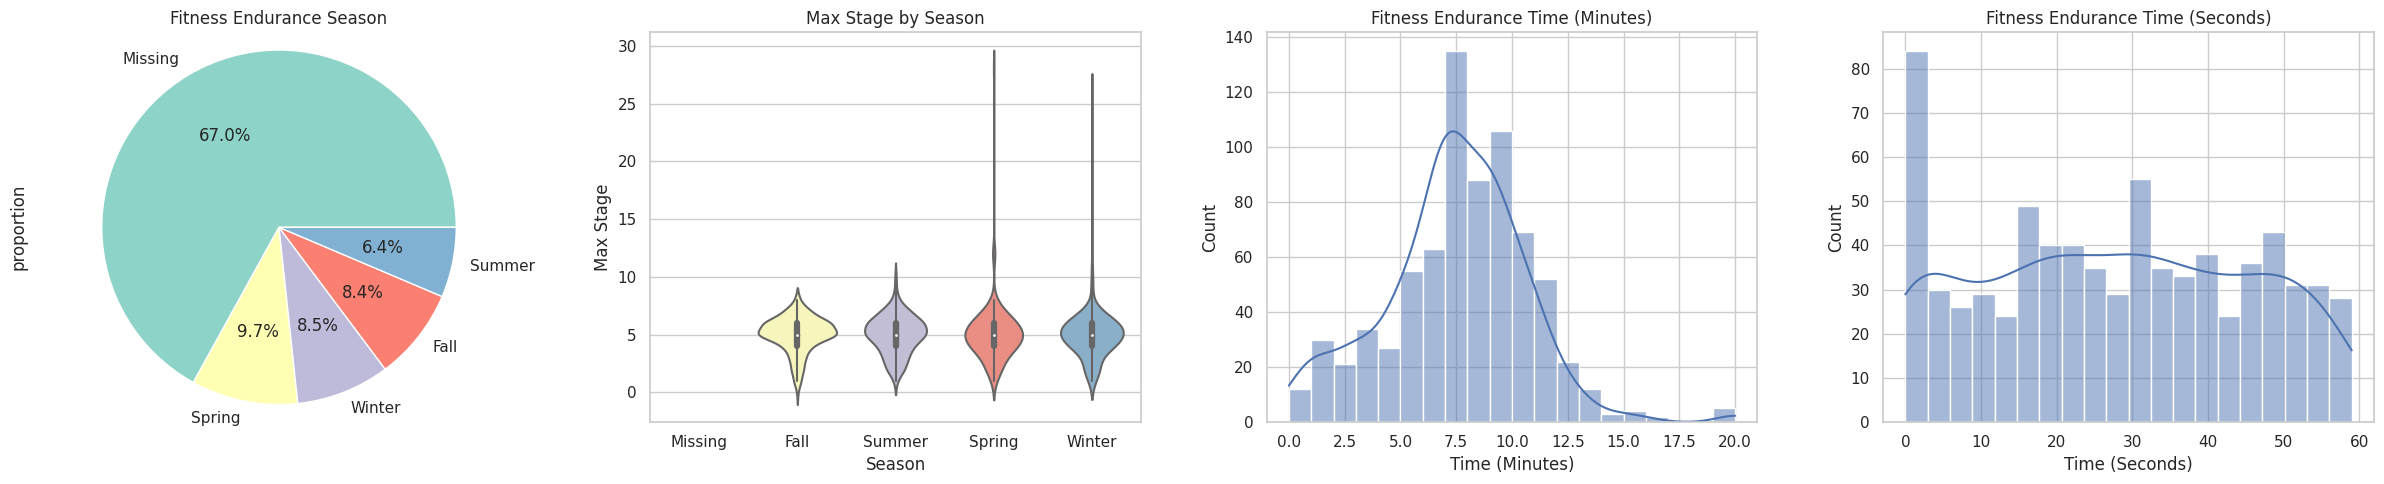

In [68]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Fitness Endurance Season
train['Fitness_Endurance-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors, ax=axes[0]
)
axes[0].set_title('Fitness Endurance Season')
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Box plot for Max Stage by Season
sns.violinplot(
    x='Fitness_Endurance-Season',
    y='Fitness_Endurance-Max_Stage',
    data=train, palette="Set3",
    ax=axes[1]
)
axes[1].set_title('Max Stage by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Max Stage')

# Fitness Endurance Time (Minutes)
sns.histplot(train['Fitness_Endurance-Time_Mins'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Fitness Endurance Time (Minutes)')
axes[2].set_xlabel('Time (Minutes)')

# Fitness Endurance Time (Seconds)
sns.histplot(train['Fitness_Endurance-Time_Sec'], bins=20, kde=True, ax=axes[3])
axes[3].set_title('Fitness Endurance Time (Seconds)')
axes[3].set_xlabel('Time (Seconds)')

plt.tight_layout()
plt.show()

Endurance by age:

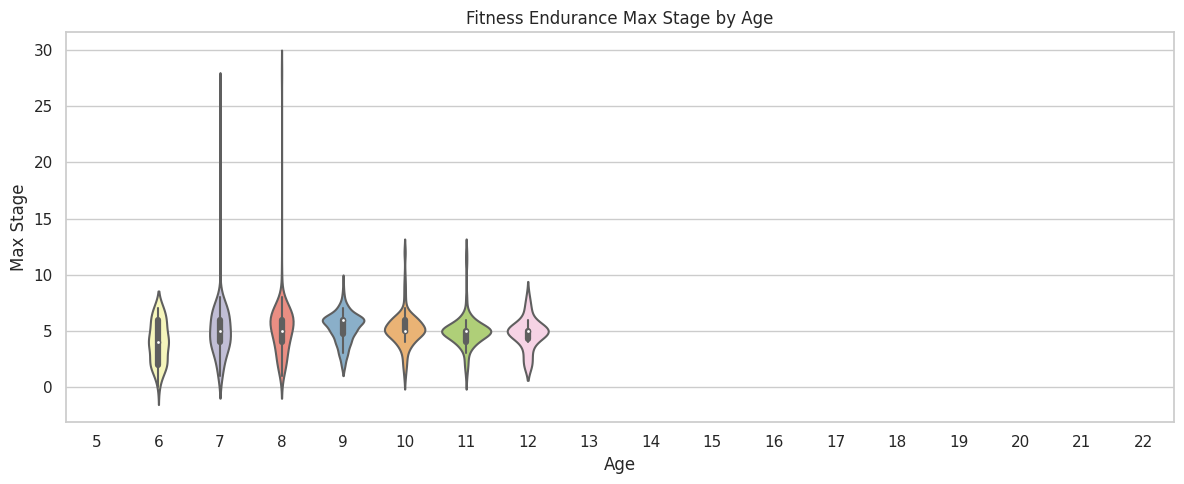

In [69]:
plt.figure(figsize=(12, 5))

sns.violinplot(x='Basic_Demos-Age', y='Fitness_Endurance-Max_Stage', data=train, palette="Set3")
plt.title('Fitness Endurance Max Stage by Age')
plt.xlabel('Age')
plt.ylabel('Max Stage')

plt.tight_layout()
plt.show()

In [70]:
calculate_stats(train, [
     'Fitness_Endurance-Max_Stage',
     'Fitness_Endurance-Time_Mins',
     'Fitness_Endurance-Time_Sec'
])

,count,mean,std,min,25%,50%,75%,max,missing
Fitness_Endurance-Max_Stage,743.0,4.989233,2.014072,0.0,4.00,5.0,6.0,28.0,3217
Fitness_Endurance-Time_Mins,740.0,7.370270,3.189662,0.0,6.00,7.0,9.0,20.0,3220
Fitness_Endurance-Time_Sec,740.0,27.581081,17.707751,0.0,12.75,28.0,43.0,59.0,3220


- Fitness_Endurance-Max_Stage: likely represents the maximum stage reached during an endurance test. In fitness endurance tests like a treadmill test or a multi-stage fitness test (beep test), participants progress through increasing levels of difficulty (speed or incline), and this column records the highest level or stage completed by the participant before stopping.
- Fitness_Endurance-Time_Mins: could be the duration a participant was able to sustain the test before reaching exhaustion, measured in minutes
- Fitness_Endurance-Time_Sec: I guess combining both columns (minutes and seconds) would give the exact total time of the endurance test completed by the participants.

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>On average, participants reached stage 5 in the endurance test.
<li>Some participants failed to complete the first stage (min = 0), or these are errors in data again.
<li>There is a small number of participants with exceptionally high endurance of age 7-8 years.
<li>There is a substantial amount of missing data (over 80% of the dataset lacks this information).
    </ul>
</div>

### FitnessGram Child

In [71]:
data_dict[data_dict['Instrument'] == 'FitnessGram Child']

,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


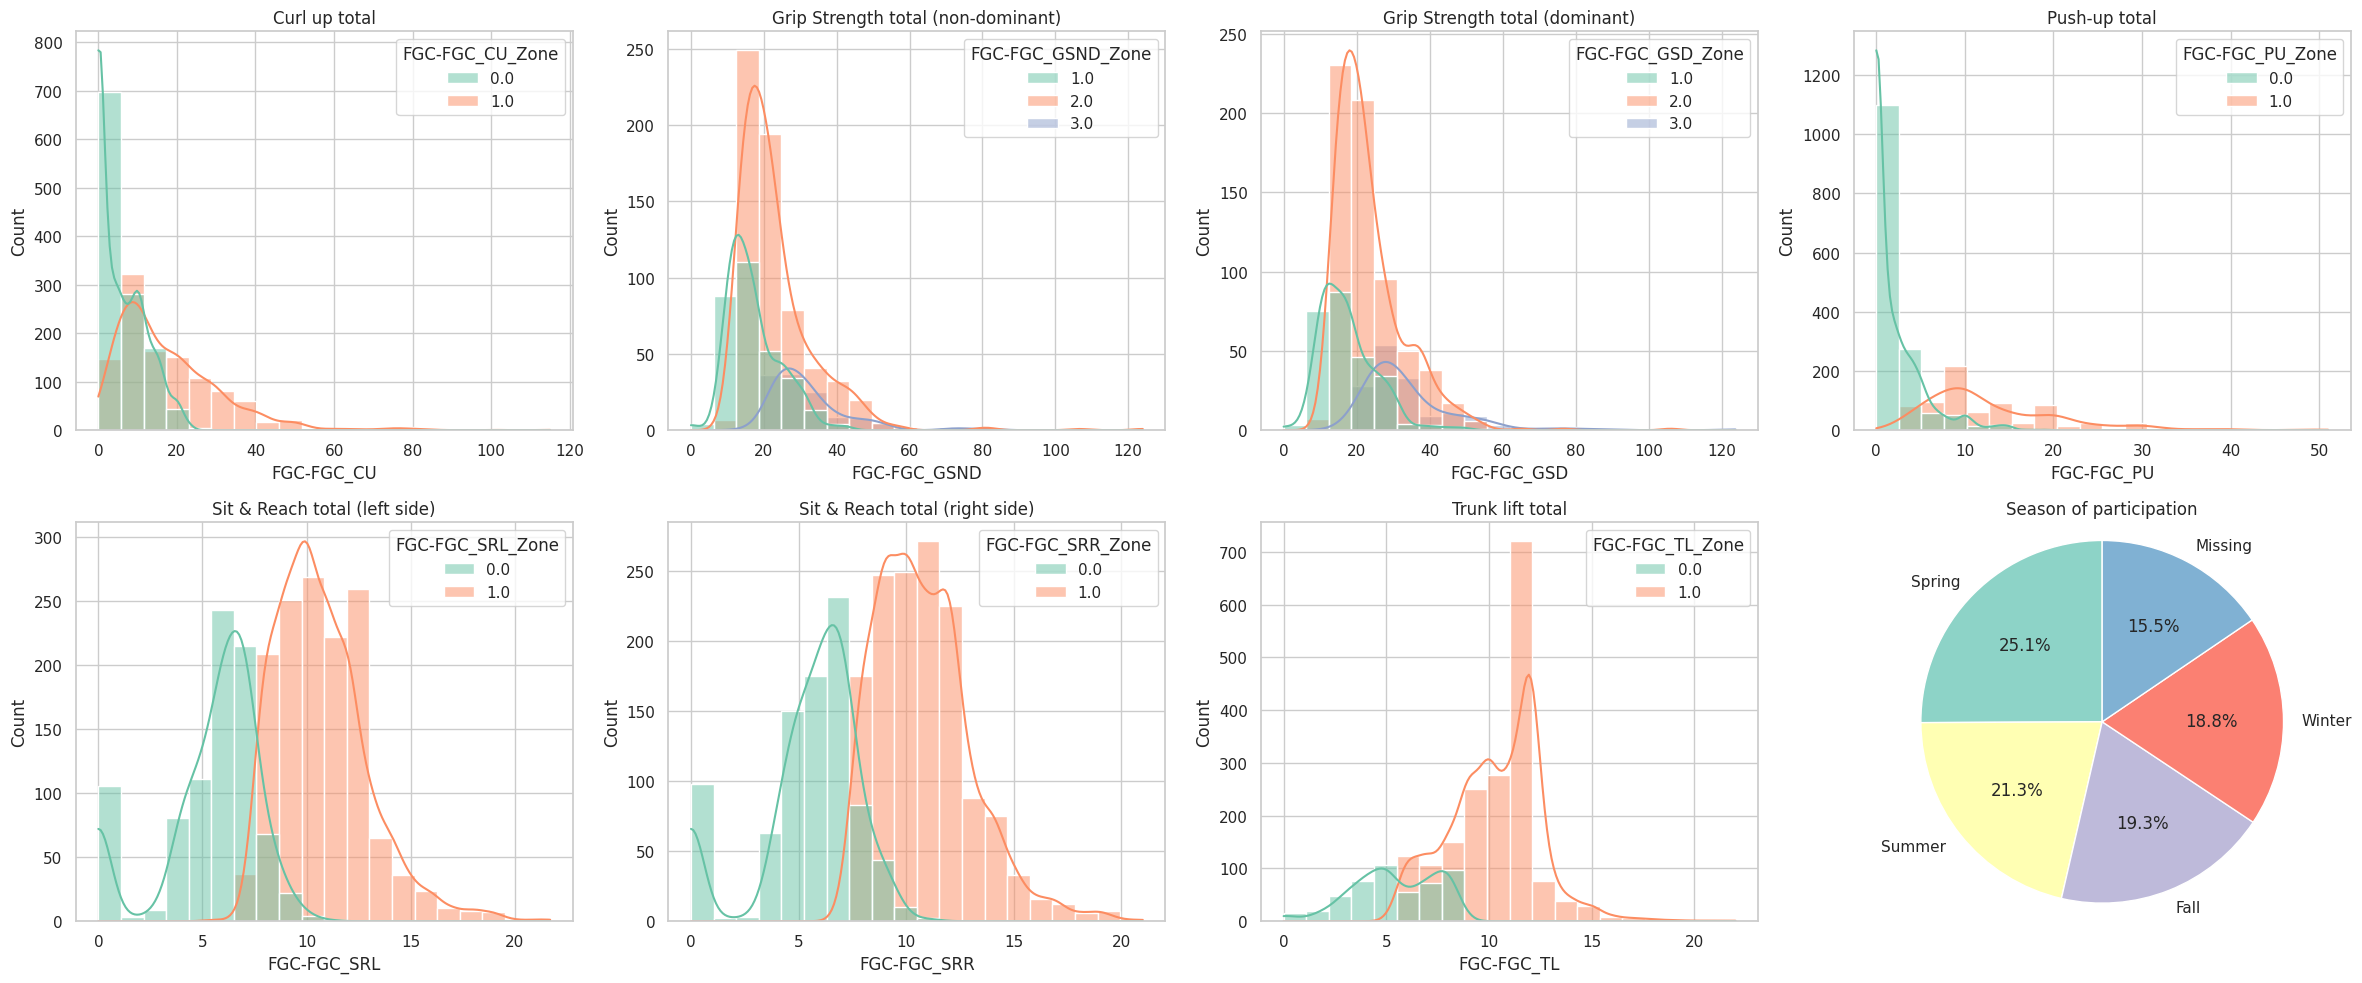

In [72]:
fgc_data_dict = data_dict[data_dict['Instrument'] == 'FitnessGram Child']

fgc_columns = []

for index, row in fgc_data_dict.iterrows():
    if '_Zone' not in row['Field']:
        measure_field = row['Field']
        measure_desc = row['Description']
        
        zone_field = measure_field + '_Zone'
        zone_row = fgc_data_dict[fgc_data_dict['Field'] == zone_field]
        
        if not zone_row.empty:
            zone_desc = zone_row['Description'].values[0]
            fgc_columns.append((measure_field, zone_field, measure_desc, zone_desc))
            
fig, axes = plt.subplots(2, 4, figsize=(24, 10))

for idx, (measure, zone, measure_desc, zone_desc) in enumerate(fgc_columns):
    row = idx // 4
    col = idx % 4
    
    sns.histplot(
        data=train, x=measure,
        hue=zone, bins=20, palette='Set2',
        ax=axes[row, col], kde=True
    )
    axes[row, col].set_title(f'{measure_desc}')

season_counts = train['FGC-Season'].value_counts(normalize=True)
axes[1, 3].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[1, 3].set_title('Season of participation')
axes[1, 3].axis('equal') 

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Most of the distributions are skewed towards lower performance totals.
<li>Strangely, a greater proportion of participants achieved a healthy fitness zone for the trunk lift.
<li>Strange that the values for different zones overlap significantly, I would expect different ranges for each zone.
    </ul>
</div>

In [73]:
measurement_columns = [measure for measure, _, _, _ in fgc_columns]
calculate_stats(train, measurement_columns)

,count,mean,std,min,25%,50%,75%,max,missing
FGC-FGC_CU,2322.0,11.259690,11.807781,0.0,3.0,9.00,15.750,115.0,1638
FGC-FGC_GSND,1074.0,22.420438,10.833995,0.0,15.1,20.05,26.600,124.0,2886
FGC-FGC_GSD,1074.0,23.518622,11.148951,0.0,16.2,21.20,28.175,123.8,2886
FGC-FGC_PU,2310.0,5.579654,7.390161,0.0,0.0,3.00,9.000,51.0,1650
FGC-FGC_SRL,2305.0,8.694924,3.429301,0.0,7.0,9.00,11.000,21.7,1655
FGC-FGC_SRR,2307.0,8.805635,3.422167,0.0,7.0,9.00,11.000,21.0,1653
FGC-FGC_TL,2324.0,9.252775,2.988863,0.0,7.0,10.00,12.000,22.0,1636


### Overlap between fitness zones

Output ranges for each measure and zone:

In [74]:
results = {}
for measure, zone, _, _ in fgc_columns:
    stats = []
    sorted_zones = sorted(train[zone].dropna().unique())
    for zone_value in sorted_zones: 
        zone_data = train[train[zone] == zone_value][measure]
        
        if not zone_data.empty:
            stats.append({
                'Zone': int(zone_value),
                'Min': zone_data.min(),
                'Max': zone_data.max()
            })
    stats_df = pd.DataFrame(stats).set_index('Zone').T
    results[measure] = stats_df

pd.concat(results, axis=1)

FGC-FGC_CU        FGC-FGC_GSND              FGC-FGC_GSD                \
Zone          0      1            1      2     3           1      2      3   
Min         0.0    2.0          0.0    9.0  15.5         0.0    9.5   16.3   
Max        23.0  115.0         43.0  124.0  81.8        49.8  106.0  123.8   

     FGC-FGC_PU       FGC-FGC_SRL       FGC-FGC_SRR       FGC-FGC_TL        
Zone          0     1           0     1           0     1          0     1  
Min         0.0   3.0         0.0   5.5         0.0   7.0        0.0   5.5  
Max        19.0  51.0        11.0  21.7        11.0  21.0        8.5  22.0

The overlap between fitness zones in the FitnessGram is not clear for me. May me I didn't get what these data represent.

### Age Ranges for each measurement column

In [75]:
age_ranges = []

for measure in measurement_columns:
    valid_rows = train[~train[measure].isna()]
    
    min_age = valid_rows['Basic_Demos-Age'].min()
    max_age = valid_rows['Basic_Demos-Age'].max()
    
    age_ranges.append({
        'Measurement': measure,
        'Min Age': min_age,
        'Max Age': max_age
    })

age_ranges_df = pd.DataFrame(age_ranges)
age_ranges_df

,Measurement,Min Age,Max Age
0,FGC-FGC_CU,5,21
1,FGC-FGC_GSND,6,21
2,FGC-FGC_GSD,6,21
3,FGC-FGC_PU,5,21
4,FGC-FGC_SRL,5,21
5,FGC-FGC_SRR,5,21
6,FGC-FGC_TL,5,21


It also doesn't make sense to call this a children's FitnessGram, since participants of almost all ages (5-21) were tested.

# - Bio-electric Impedance Analysis

In [76]:
data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']

,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


In [77]:
bia_data_dict = data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']
categorical_columns = bia_data_dict[bia_data_dict['Type'] == 'categorical int']['Field'].tolist()
continuous_columns = bia_data_dict[bia_data_dict['Type'] == 'float']['Field'].tolist()

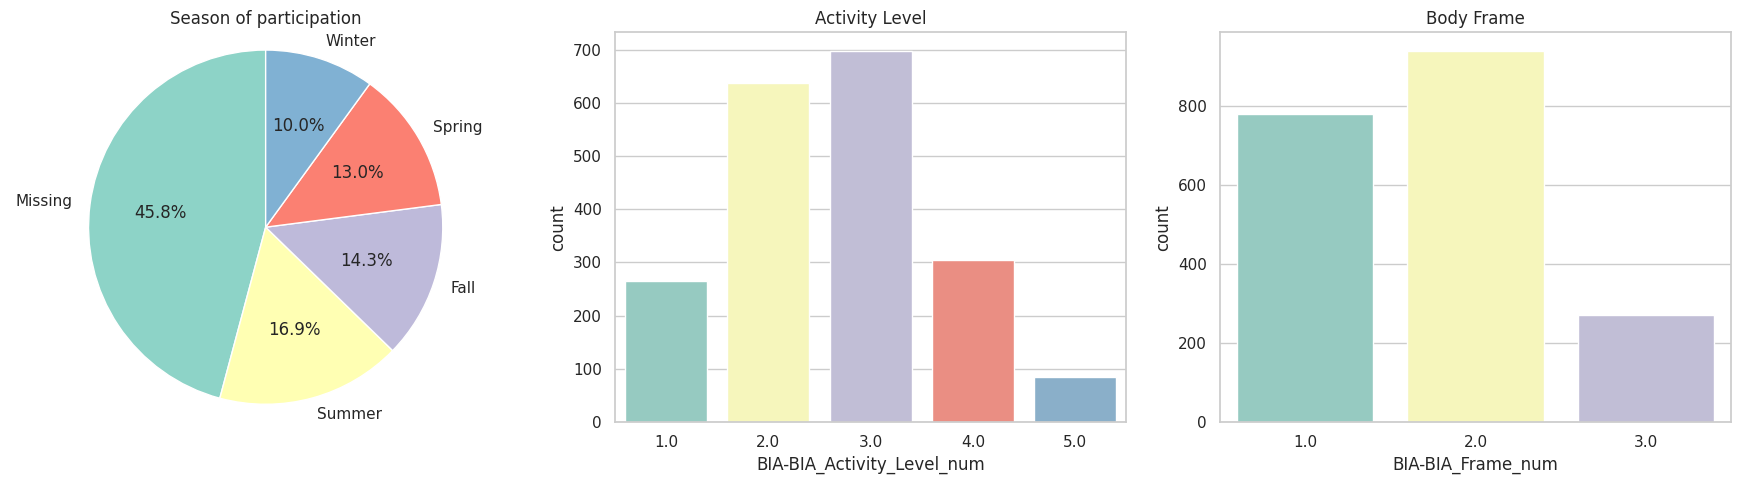

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Season
season_counts = train['BIA-Season'].value_counts(normalize=True)
axes[0].pie(
    season_counts, 
    labels=season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
axes[0].set_title(
    f"{bia_data_dict[bia_data_dict['Field'] == 'BIA-Season']['Description'].values[0]}"
)
axes[0].axis('equal')

# Other categorical columns
for idx, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train, palette="Set3", ax=axes[idx+1])
    axes[idx+1].set_title(data_dict[data_dict['Field'] == col]['Description'].values[0])

plt.tight_layout()
plt.show()

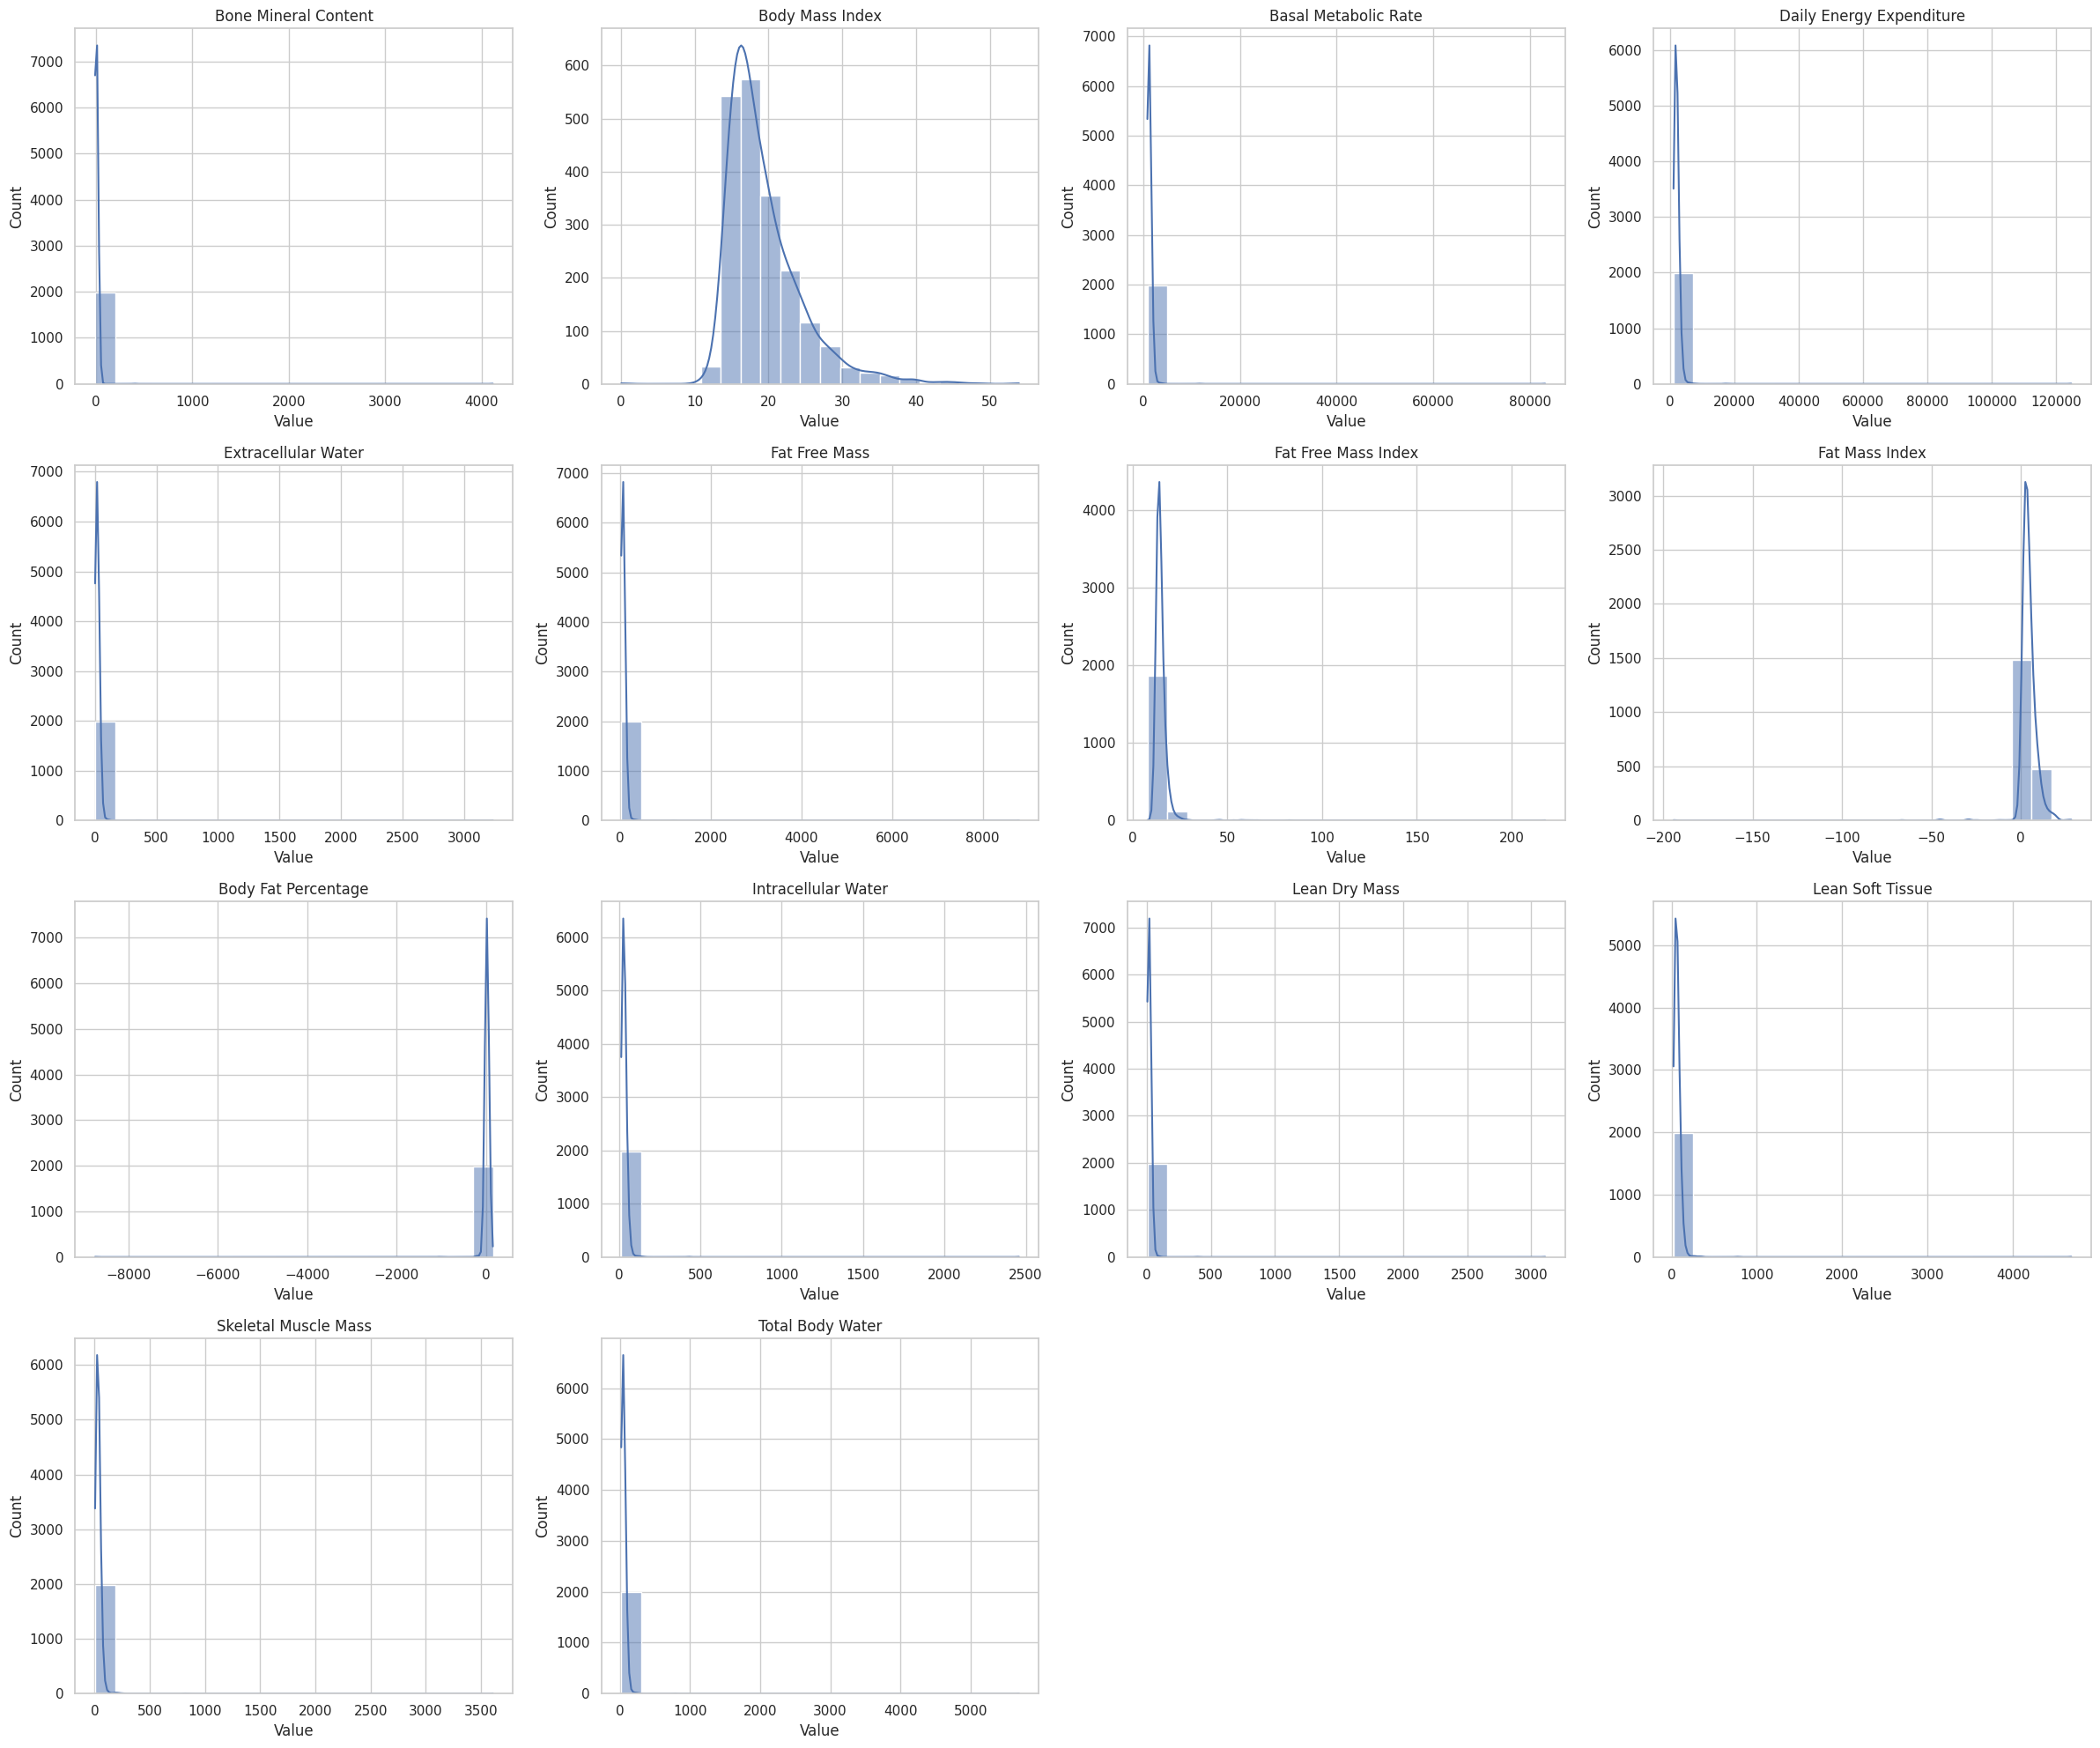

In [79]:
plt.figure(figsize=(24, 20))

for idx, col in enumerate(continuous_columns):
    plt.subplot(4, 4, idx + 1)
    sns.histplot(train[col].dropna(), bins=20, kde=True)
    plt.title(data_dict[data_dict['Field'] == col]['Description'].values[0])
    plt.xlabel('Value')

plt.tight_layout()
plt.show()

In [80]:
calculate_stats(train, continuous_columns)

,count,mean,std,min,25%,50%,75%,max,missing
BIA-BIA_BMC,1991.0,6.719826,92.586325,-7.789610,2.966905,3.92272,5.460925,4115.3600,1969
BIA-BIA_BMI,1991.0,19.367048,5.047848,0.048267,15.913600,17.96650,21.461100,53.9243,1969
BIA-BIA_BMR,1991.0,1237.018187,1872.383246,813.397000,1004.710000,1115.38000,1310.360000,83152.2000,1969
BIA-BIA_DEE,1991.0,2064.693747,2836.246272,1073.450000,1605.785000,1863.98000,2218.145000,124728.0000,1969
BIA-BIA_ECW,1991.0,20.825346,73.266287,1.789450,11.109550,15.92800,25.162200,3233.0000,1969
BIA-BIA_FFM,1991.0,74.021708,199.433753,28.900400,49.278100,61.06620,81.833800,8799.0800,1969
BIA-BIA_FFMI,1991.0,15.030554,5.792505,7.864850,13.408000,14.09250,15.430950,217.7710,1969
BIA-BIA_FMI,1991.0,4.336495,6.356402,-194.163000,2.306915,3.69863,5.987690,28.2515,1969
BIA-BIA_Fat,1991.0,16.855020,199.372119,-8745.080000,8.602395,16.17460,30.273100,153.8200,1969
BIA-BIA_ICW,1991.0,33.173380,56.272346,14.489000,24.463500,28.85580,35.475700,2457.9100,1969


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The distribution of the various bioelectrical impedance analysis measurements in the data set indicates that most of them are not useful: highly skewed, with the majority of participants having marginal values and a few outliers (potential measurement errors).
<li>Some variables, such as Fat Mass Index and Body Fat Percentage, show implausible negative values, and almost all - extreme high values, indicating potential data quality issues
    </ul>
</div>

### Compare the two measured BMI

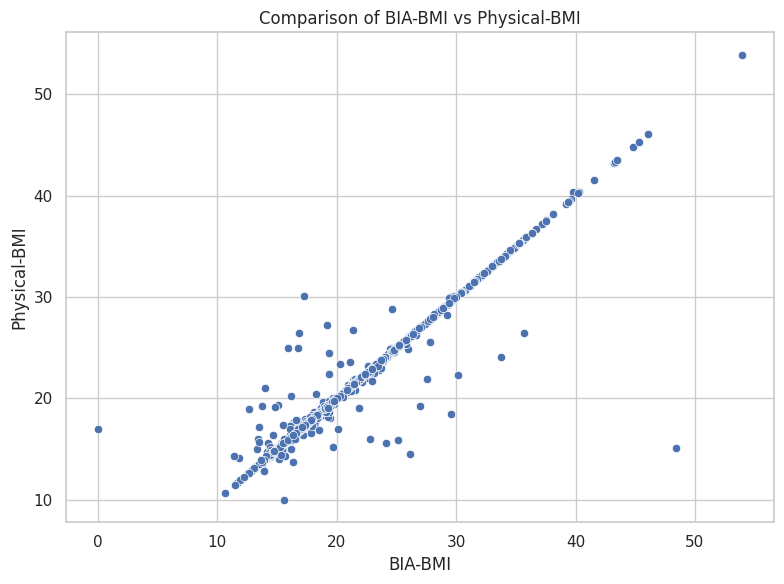

In [81]:
bmi_data = train[['BIA-BIA_BMI', 'Physical-BMI']].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='BIA-BIA_BMI', y='Physical-BMI',
    data=bmi_data,
    color='b'
)
plt.title('Comparison of BIA-BMI vs Physical-BMI')
plt.xlabel('BIA-BMI')
plt.ylabel('Physical-BMI')

plt.tight_layout()
plt.show()

In [82]:
bmi_measures = train[['BIA-Season', 'Physical-Season']].dropna()
bmi_measures.groupby(['BIA-Season', 'Physical-Season']).size().reset_index(name='Count')

,BIA-Season,Physical-Season,Count
0,Fall,Fall,407
1,Fall,Missing,6
2,Fall,Spring,15
3,Fall,Summer,131
4,Fall,Winter,8
5,Missing,Fall,294
6,Missing,Missing,635
7,Missing,Spring,309
8,Missing,Summer,277
9,Missing,Winter,300


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: This may not be exactly correct, because above I found zeros in the physical measurements and recalculated the BMI... As we can see, this BMI measured during the bioelectrical impedance also contains zeros that I cannot explain and that seem to be errors.
</div>

# - Sleep Disturbance Scale

In [83]:
groups.get('Sleep Disturbance Scale', [])

['SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']

In [84]:
data = train[train['SDS-SDS_Total_Raw'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with SDS-SDS_Total_Raw data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with SDS-SDS_Total_Raw data: 5 - 22 years


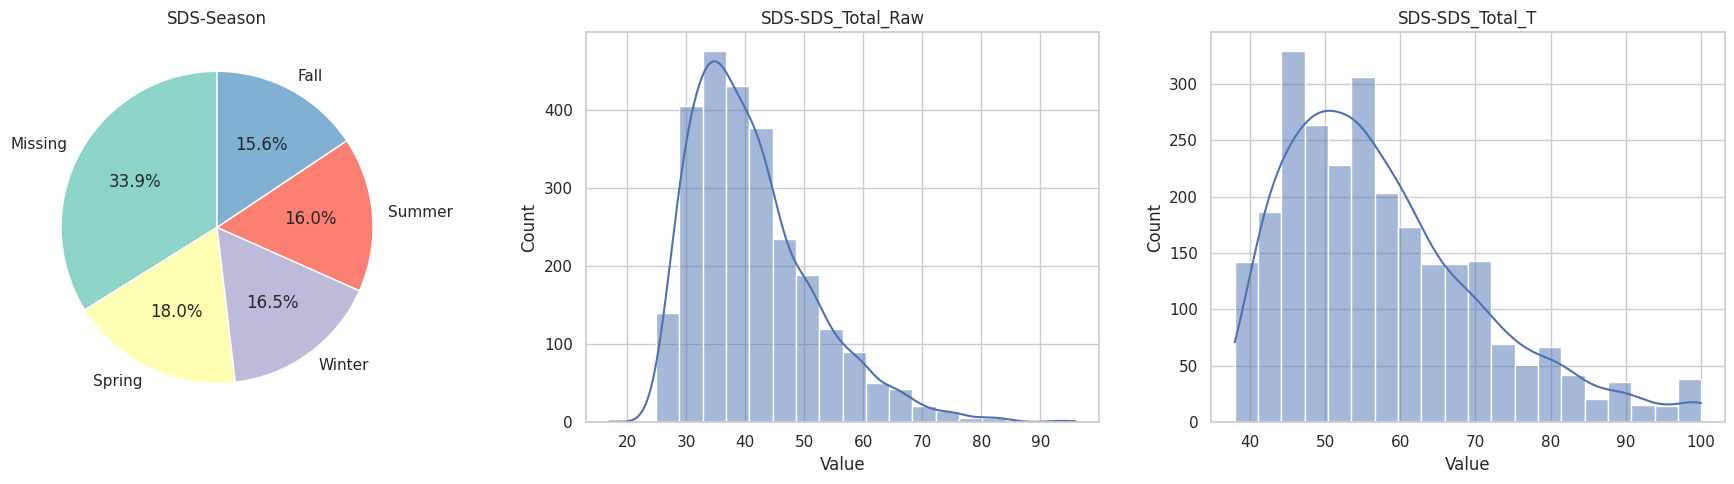

In [85]:
plt.figure(figsize=(18, 5))

# SDS-Season (Pie Chart)
plt.subplot(1, 3, 1)
sds_season_counts = train['SDS-Season'].value_counts(normalize=True)
plt.pie(
    sds_season_counts, 
    labels=sds_season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
plt.title('SDS-Season')

# SDS-SDS_Total_Raw
plt.subplot(1, 3, 2)
sns.histplot(train['SDS-SDS_Total_Raw'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_Raw')
plt.xlabel('Value')

# SDS-SDS_Total_T
plt.subplot(1, 3, 3)
sns.histplot(train['SDS-SDS_Total_T'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_T')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

In [86]:
calculate_stats(train, ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'])

,count,mean,std,min,25%,50%,75%,max,missing
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.0,39.0,46.0,96.0,1351
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.0,55.0,64.0,100.0,1354


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Both the raw and T-scores for sleep disturbance are moderately variable, with some extreme values indicating severe sleep disturbances in a subset of participants.
<li>Further Analysis (coming soon): to explore whether specific demographic factors (e.g., age, gender, season) are associated with higher sleep disturbance scores.
    </ul>
</div>

# - Children's Global Assessment Scale

In [87]:
groups.get("Children's Global Assessment Scale", [])

['CGAS-Season', 'CGAS-CGAS_Score']

In [88]:
data = train[train['CGAS-CGAS_Score'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with CGAS-CGAS_Score data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with CGAS-CGAS_Score data: 5 - 22 years


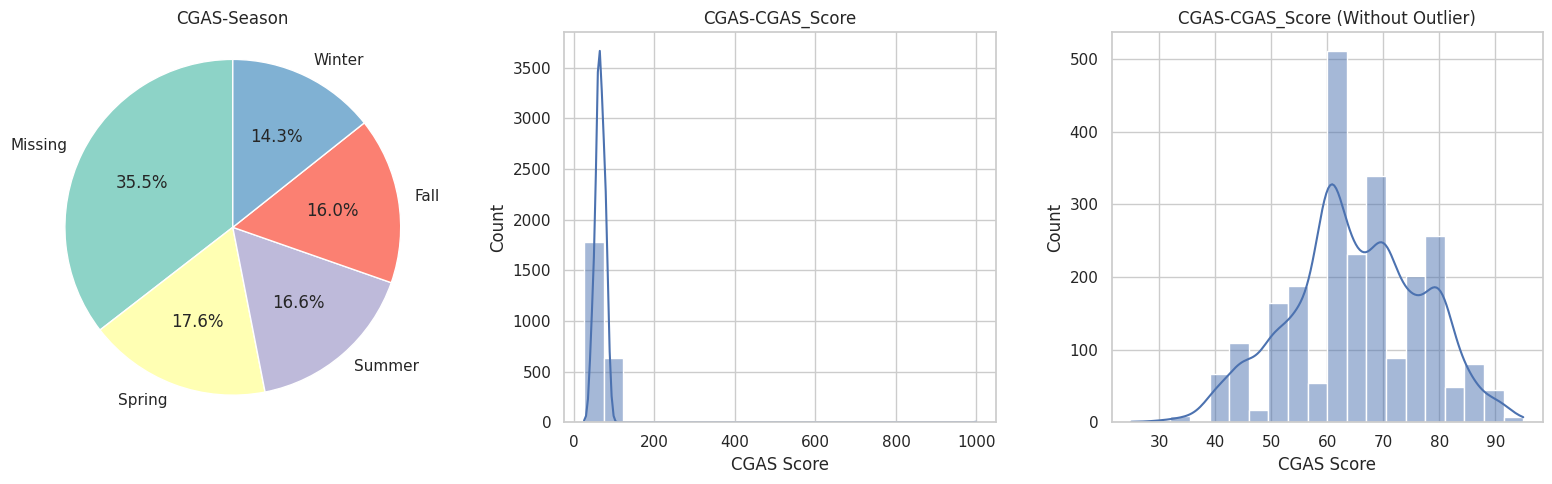

In [89]:
plt.figure(figsize=(16, 5))

# CGAS-Season
plt.subplot(1, 3, 1)
cgas_season_counts = train['CGAS-Season'].value_counts(normalize=True)
plt.pie(
    cgas_season_counts, 
    labels=cgas_season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
plt.title('CGAS-Season')
plt.axis('equal')

# CGAS-CGAS_Score
plt.subplot(1, 3, 2)
sns.histplot(train['CGAS-CGAS_Score'].dropna(), bins=20, kde=True)
plt.title('CGAS-CGAS_Score')
plt.xlabel('CGAS Score')
plt.ylabel('Count')

# CGAS-CGAS_Score without outliers (score == 999)
plt.subplot(1, 3, 3)
sns.histplot(
    train[train['CGAS-CGAS_Score'] != 999]['CGAS-CGAS_Score'].dropna(),
    bins=20, kde=True
)
plt.title('CGAS-CGAS_Score (Without Outlier)')
plt.xlabel('CGAS Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [90]:
train[train['CGAS-CGAS_Score'] > 100]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group,internet_use_encoded
2065,83525bbe,Fall,11,Female,Winter,999.0,Fall,NaN,NaN,NaN,...,NaN,NaN,Missing,NaN,NaN,Fall,3.0,Missing,Children (5-12),3 h


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>There is an extreme value outlier or other error in the data set?
    </ul>
</div>

Stats without outlier:

In [91]:
calculate_stats(train[train['CGAS-CGAS_Score'] != 999], 'CGAS-CGAS_Score')

,count,mean,std,min,25%,50%,75%,max,missing
CGAS-CGAS_Score,,,,,,,,,
CGAS-CGAS_Score,2420.0,65.069008,11.78731,25.0,59.0,65.0,75.0,95.0,1539


### CGAS Interpretation ([Reference](https://www.corc.uk.net/outcome-experience-measures/childrens-global-assessment-scale-cgas/))

CGAS is a rating of general functioning for children and young people aged 4-16 years old. The CGAS asks the clinician to rate the child from 1 to 100 based on their lowest level of functioning, regardless of treatment or prognosis, over a specified time period.

Since the CGAS is a measure of general functioning, and the SII reflects the severity of the impact of Internet use on that functioning, I expect this feature, along with Internet use, to be the most important in predicting the SII.

Let's bin the `CGAS-CGAS_Score` column based on the established score categories and draw counts:

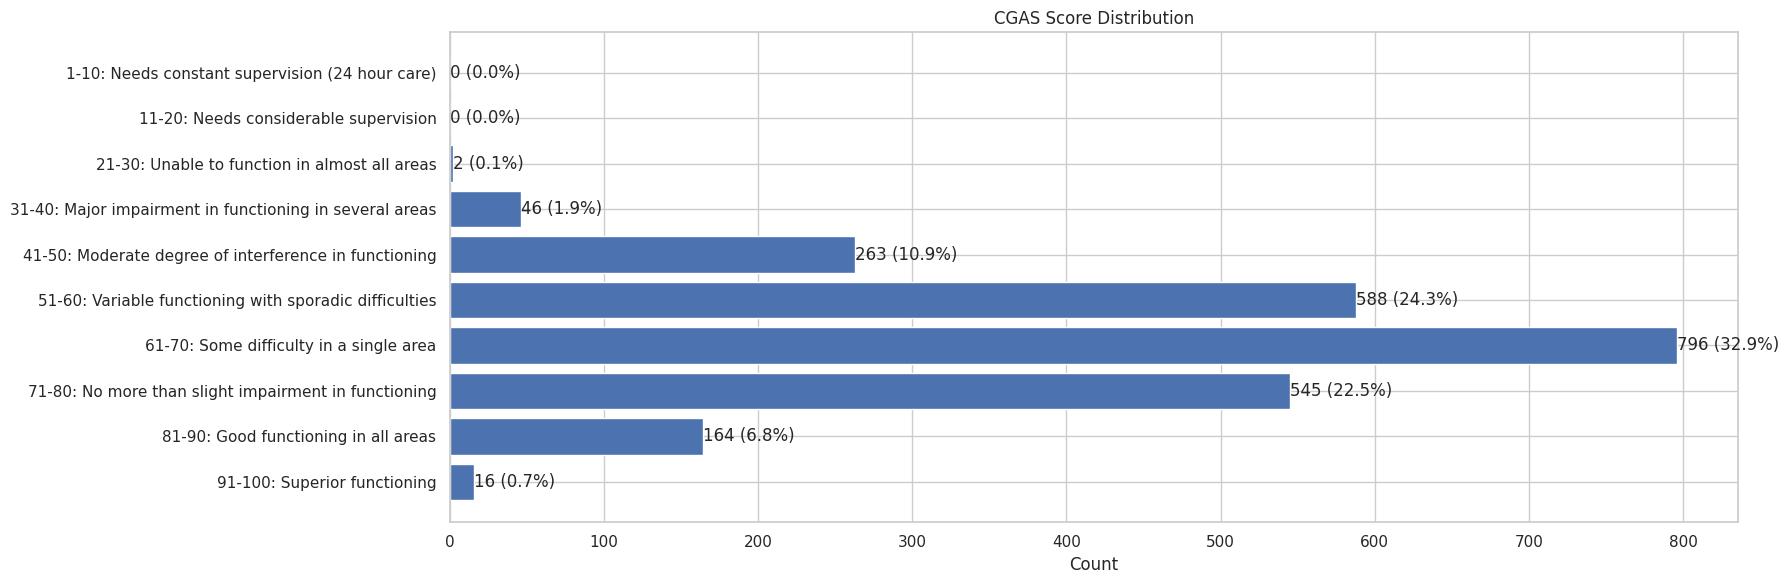

In [92]:
bins = np.arange(0, 101, 10)
labels = [
    "1-10: Needs constant supervision (24 hour care)",
    "11-20: Needs considerable supervision",
    "21-30: Unable to function in almost all areas",
    "31-40: Major impairment in functioning in several areas",
    "41-50: Moderate degree of interference in functioning",
    "51-60: Variable functioning with sporadic difficulties",
    "61-70: Some difficulty in a single area",
    "71-80: No more than slight impairment in functioning",
    "81-90: Good functioning in all areas",
    "91-100: Superior functioning"
]

train['CGAS_Score_Bin'] = pd.cut(
    train['CGAS-CGAS_Score'], bins=bins, labels=labels
)

counts = train['CGAS_Score_Bin'].value_counts().reindex(labels)
prop = (counts / counts.sum() * 100).round(1)
count_prop_labels = counts.astype(str) + " (" + prop.astype(str) + "%)"

plt.figure(figsize=(18, 6))
bars = plt.barh(labels, counts)
plt.xlabel('Count')
plt.title('CGAS Score Distribution')

for bar, label in zip(bars, count_prop_labels):
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center'
    )

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The majority of individuals have CGAS scores between 51-80 (79.7%), i.e. sporadic difficulties to only slight impairments
<li>Two participants have extreme difficulty in functioning
    </ul>
</div>

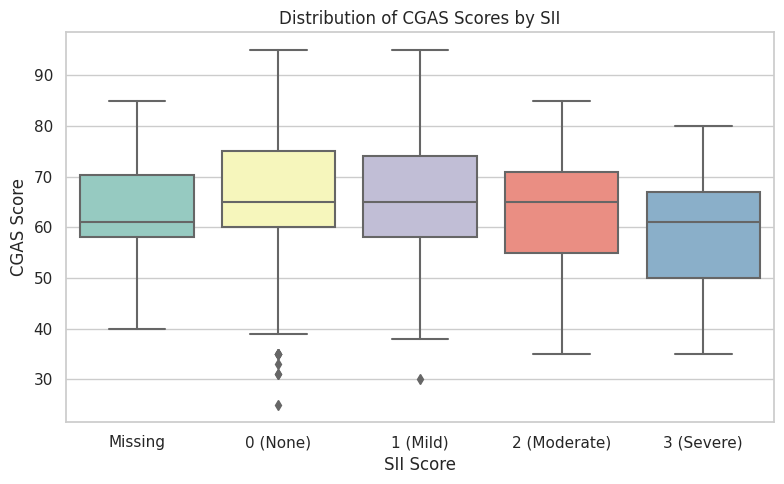

In [93]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=train[train['CGAS-CGAS_Score'] != 999],
    x='sii', y='CGAS-CGAS_Score',
    palette='Set3'
)
plt.xlabel('SII Score')
plt.ylabel('CGAS Score')
plt.title('Distribution of CGAS Scores by SII')
plt.tight_layout()
plt.show()

In [94]:
train[train['CGAS-CGAS_Score'] < 35][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

,Basic_Demos-Age,Basic_Demos-Sex,sii,CGAS-CGAS_Score,PreInt_EduHx-computerinternet_hoursday
2417,9,Female,0 (None),31.0,0.0
2525,13,Female,1 (Mild),30.0,0.0
2555,15,Male,0 (None),33.0,2.0
3332,12,Male,0 (None),25.0,2.0
3858,15,Male,0 (None),31.0,3.0


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>I would expect the higher the SII, the lower the median CGAS score, but the decrease is very small here.
<li>Interestingly, the participants with the lowest CGAS scores all have SII 0 or 1 (no or mild PIU severity) and report either no use (0.0 hours/day) or 2.0 to 3.0 hours/day of Internet use.
    </ul>
</div>